In [144]:
%load_ext autoreload
%autoreload 1
%load_ext ipycache

import json
import pandas
import os
import ipywidgets as ipyw
import matplotlib.pyplot as plt

from IPython.display import Image, display
from pprint import pprint
from ipywidgets import fixed, interactive_output
%aimport utils
from utils import *

pandas.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


# Ideas

  - If there are too many really dark pixels, the image is underexposed and discard it. Two ways to do this:
  
    1) Transform to HSV space, perform binary threshold on the Value channel. 
    2) Transform to greyscale, perform binary threshold on greyscale image
    
    In either case, if number of resulting black pixels is too large, image is underexposed
  - Same as above but with light pixels. So "inverted" binary threshold (or something like that)

# Technical Model

In [105]:
if not os.path.isfile("output-technical.log"):
    run_idealo_iqa("technical", rebuild=False, gpu=False)
TEST = False

In [106]:
scores = load_data("output-technical.log")

In [107]:
df = pandas.DataFrame(scores)
if TEST:
   df = df.sample(n=500) 
   cache_args = "--force"
else:
   cache_args = ""

In [109]:
%%cache -f image_stats.pkl stats
stats = compute_image_statistics_parallel(df, base="./test_images/")

[Saved variables 'stats' to file '/home/kyle/WEI/image-quality-assessment/image_stats.pkl'.]


In [110]:
for k, v in stats.items():
    df[k] = v
df

image_id  \
0                  bottom_no-ambient_colorhalogen_led-brightness1_exposure750_color-temp7200_left-strip-linear-fade-back-dim   
1                             middle_coloryellow-5500k_led-brightness0.5_exposure2000_color-temp6200_right-strip-linear-fade   
2                    bottom_no-ambient_colorcarbon-arc_led-brightness0.75_exposure500_color-tempauto_right-strip-linear-fade   
3                      bottom_no-ambient_colorcarbon-arc_led-brightness0.5_exposure750_color-temp5200_left-strip-linear-fade   
4                       middle_colorfull-spectrum-flourescent_led-brightness0.5_exposure2000_color-temp5200_right-strip-only   
...                                                                                                                      ...   
14395     bottom_no-ambient_coloryellow-5000k_led-brightness0.75_exposure1000_color-temp4200_left-strip-linear-fade-back-dim   
14396             middle_colorwarm-flourescent_led-brightness0.5_exposure750_color-tempauto_right-strip-linear-fade-back-dim   
14397    middle_colorfull-spectrum-flourescent_led-brightness0.5_exposure1000_color-temp2200_left-right-linear-fade-back-dim   
14398       bottom_no-ambient_colorcarbon-arc_led-brightness0.75_exposure1000_color-temp3200_linear-fade-towards-back-middle   
14399  bottom_no-ambient_colorwarm-flourescent_led-brightness0.75_exposure750_color-temp6200_linear-fade-towards-back-middle   

      location     score                       orientation  \
0       bottom  5.349301   left-strip-linear-fade-back-dim   
1       middle  4.410674           right-strip-linear-fade   
2       bottom  5.017894           right-strip-linear-fade   
3       bottom  4.491726            left-strip-linear-fade   
4       middle  4.006542                  right-strip-only   
...        ...       ...                               ...   
14395   bottom  4.081025   left-strip-linear-fade-back-dim   
14396   middle  3.866622  right-strip-linear-fade-back-dim   
14397   middle  3.682455   left-right-linear-fade-back-dim   
14398   bottom  4.848329   linear-fade-towards-back-middle   
14399   bottom  5.280743   linear-fade-towards-back-middle   

                           color  led-brightness  exposure  color-temp  \
0                        halogen            1.00       750        7200   
1                   yellow-5500k            0.50      2000        6200   
2                     carbon-arc            0.75       500           0   
3                     carbon-arc            0.50       750        5200   
4      full-spectrum-flourescent            0.50      2000        5200   
...                          ...             ...       ...         ...   
14395               yellow-5000k            0.75      1000        4200   
14396           warm-flourescent            0.50       750           0   
14397  full-spectrum-flourescent            0.50      1000        2200   
14398                 carbon-arc            0.75      1000        3200   
14399           warm-flourescent            0.75       750        6200   

       autobalance    hue_mean  saturation_mean  value_mean  
0            False  149.211570       106.920029  130.952403  
1            False  129.229833       216.600681   26.393896  
2             True  126.346174       163.605246  114.902515  
3            False  127.020081       174.972878  113.184697  
4            False  121.116498       226.033984   30.514626  
...            ...         ...              ...         ...  
14395        False  126.404635       139.739394  132.247151  
14396         True  121.984978       213.826900   71.816777  
14397        False  118.116386       224.648758   74.146243  
14398        False  122.659039       193.168911  113.141353  
14399        False  144.879376       188.730635   56.975244  

[14400 rows x 12 columns]

In [113]:
has_yellow = df["image_id"].str.contains("yellow") 
is_off = df["color"]=="off"
brightness_eq_1 = df["led-brightness"]==1
brightness_eq_75 = df["led-brightness"]==0.75
exposure2000 = df["exposure"]==2000
exposure1000 = df["exposure"]==1000
full_strip = df["orientation"]=="full-strip"

In [114]:
ui, out = build_widgets(df, plot=False)
display(ui, out)

Output()

In [ ]:
df.nlargest(10, "score")

In [151]:
imgs = get_images_matching_criteria(df, "./test_images/", criteria=df["value_mean"]<75, sort_by="value_mean", count=20, ascending=False)
display_images(imgs)

20


In [152]:
imgs = get_images_matching_criteria(df, "./test_images/", criteria=df["value_mean"]<75, sort_by="value_mean", ascending=False)
print(len(imgs))
create_zip_from_paths(imgs, "avg_value_less_than_75.zip")

7003


./test_images/bottom_no-ambient_coloryellow-5000k_led-brightness1_exposure500_color-temp4200_left-right-linear-fade.jpg


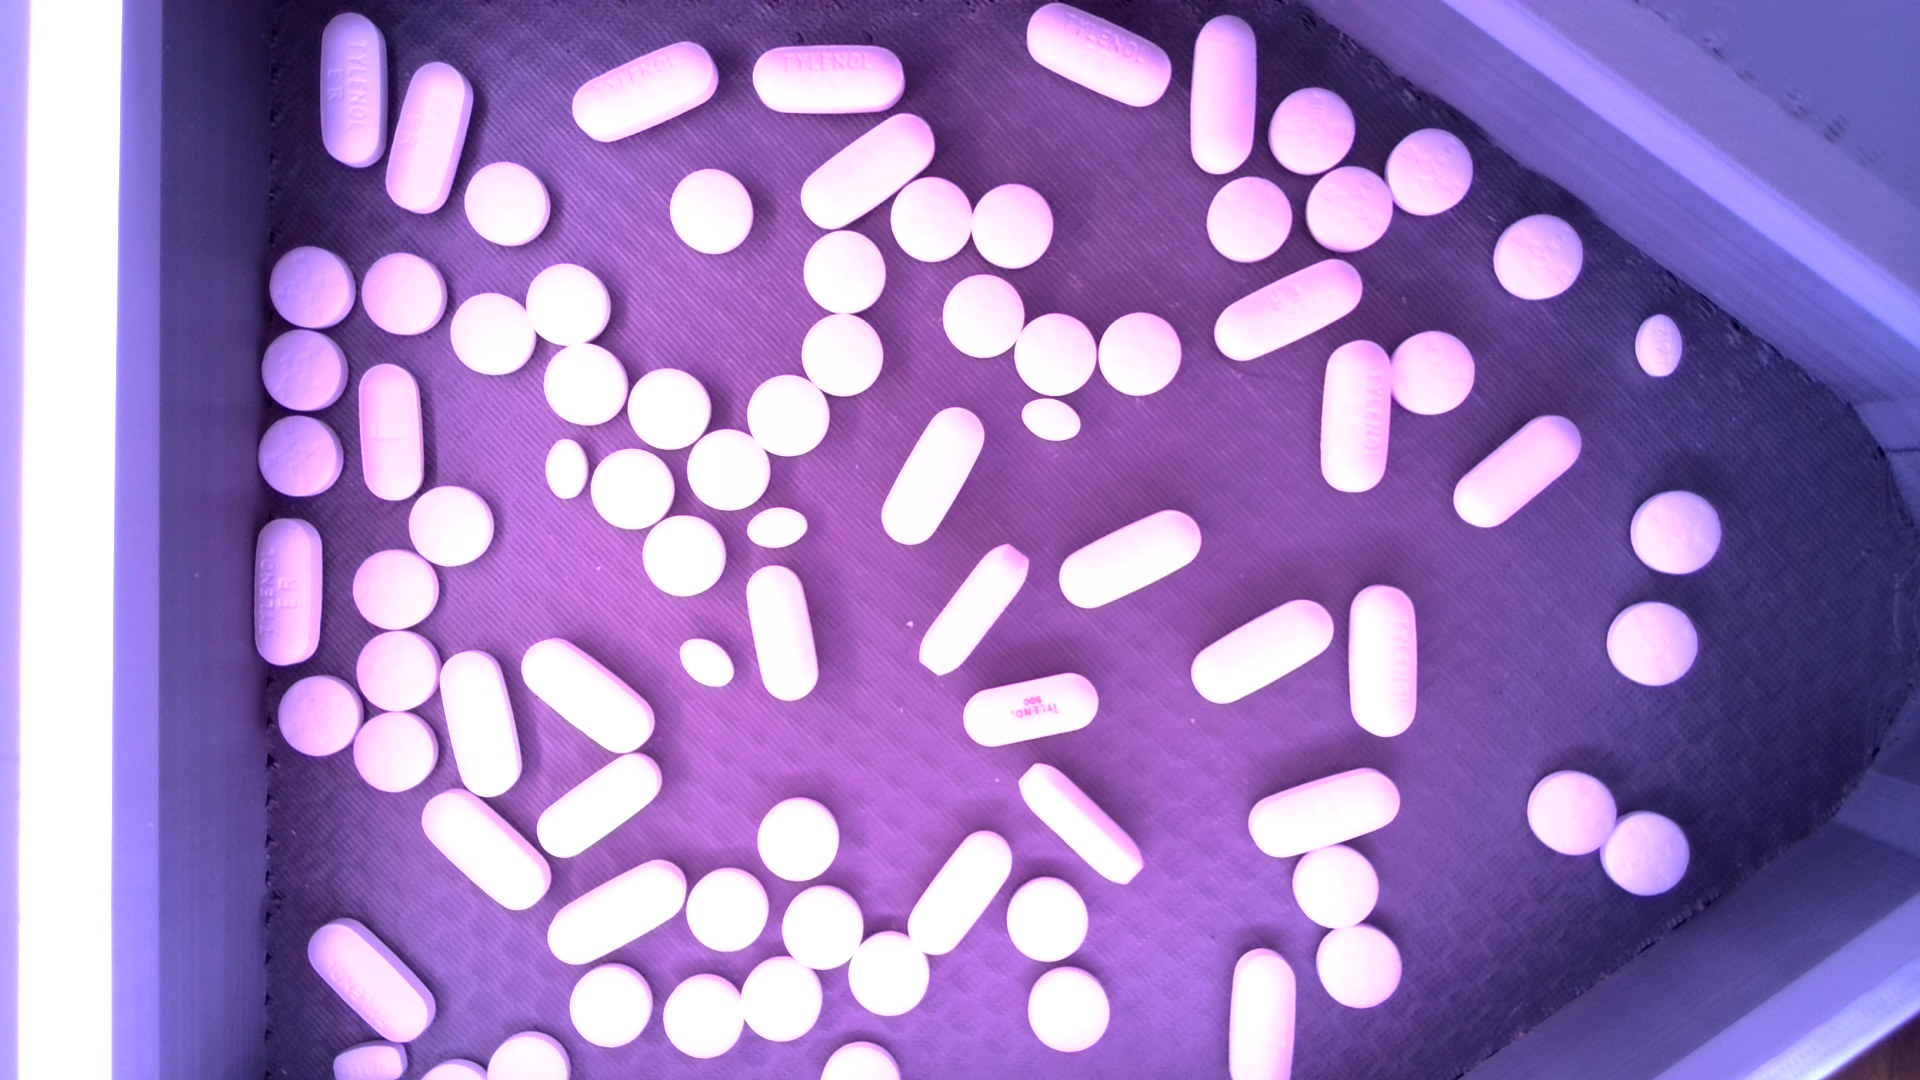

./test_images/middle_coloryellow-5000k_led-brightness0.5_exposure750_color-tempauto_full-strip.jpg


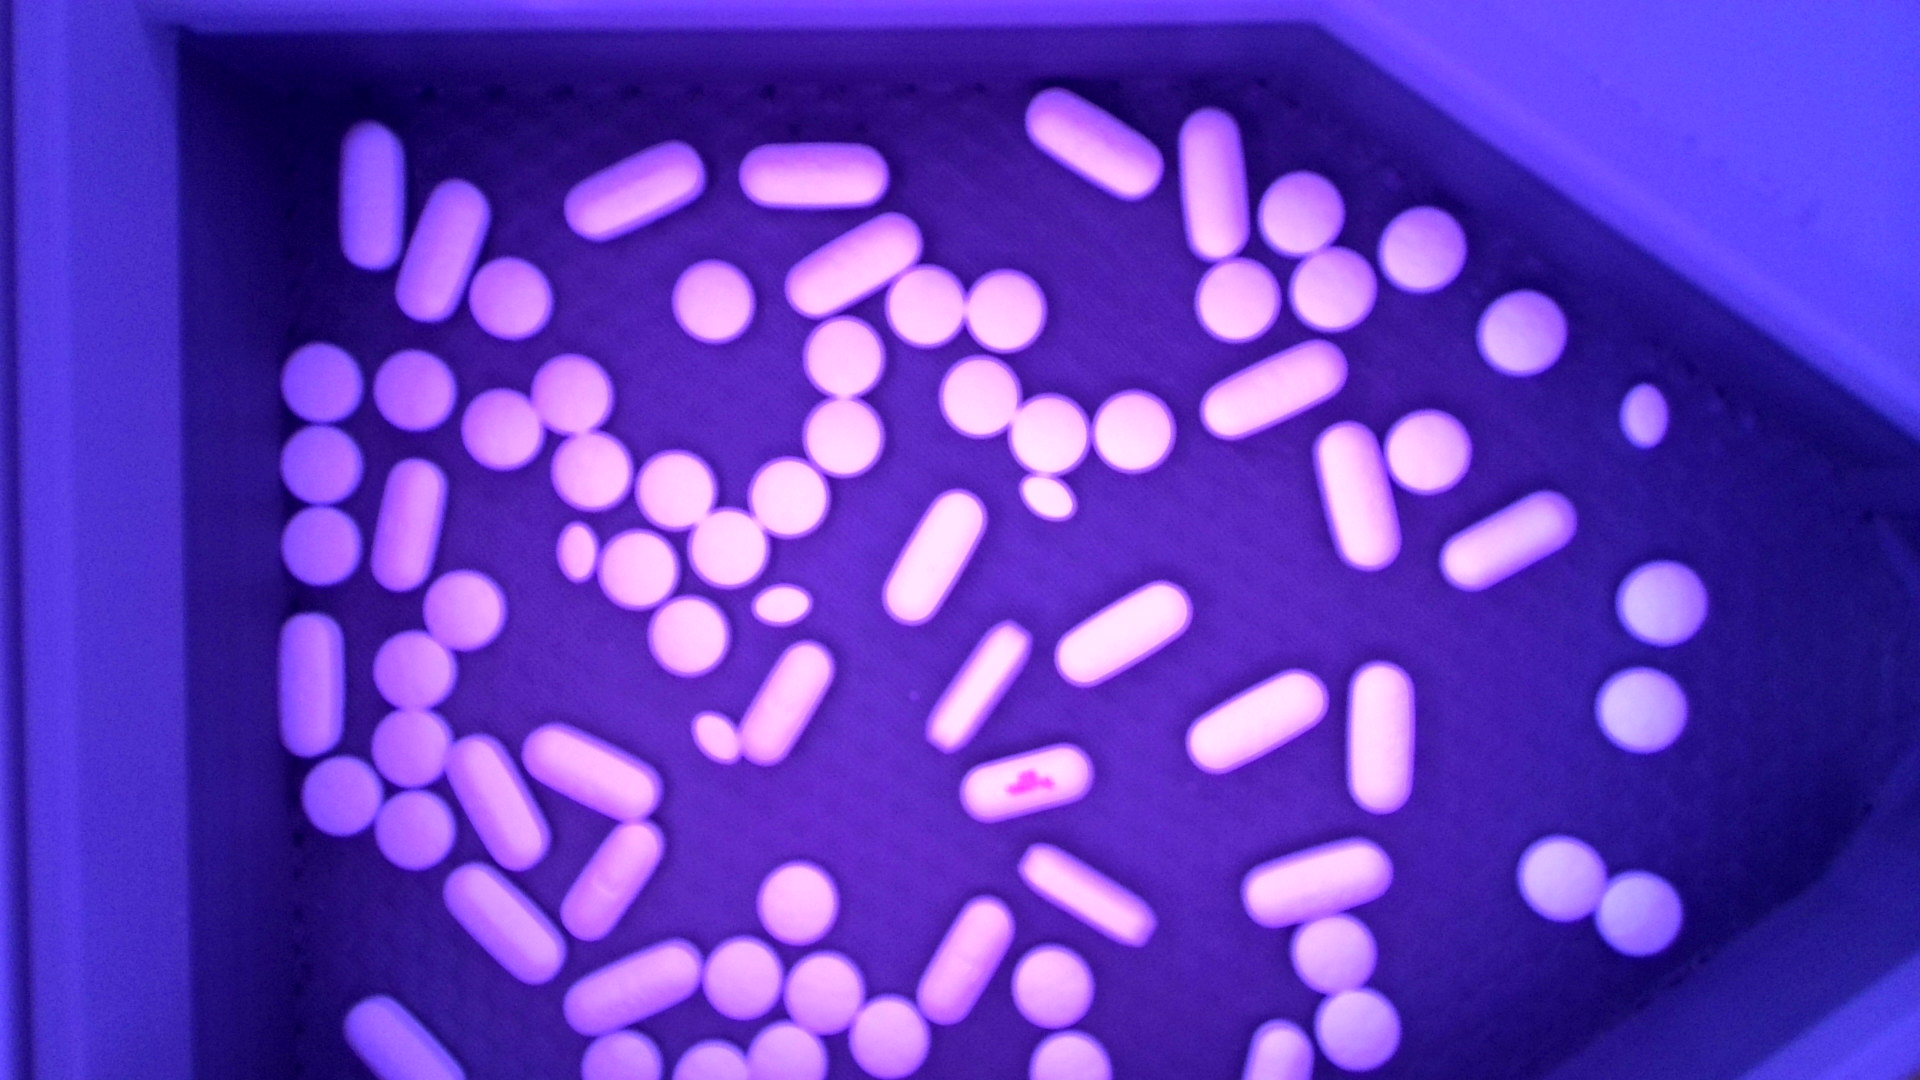

./test_images/middle_colorwarm-flourescent_led-brightness0.5_exposure1000_color-temp4600_left-right-linear-fade.jpg


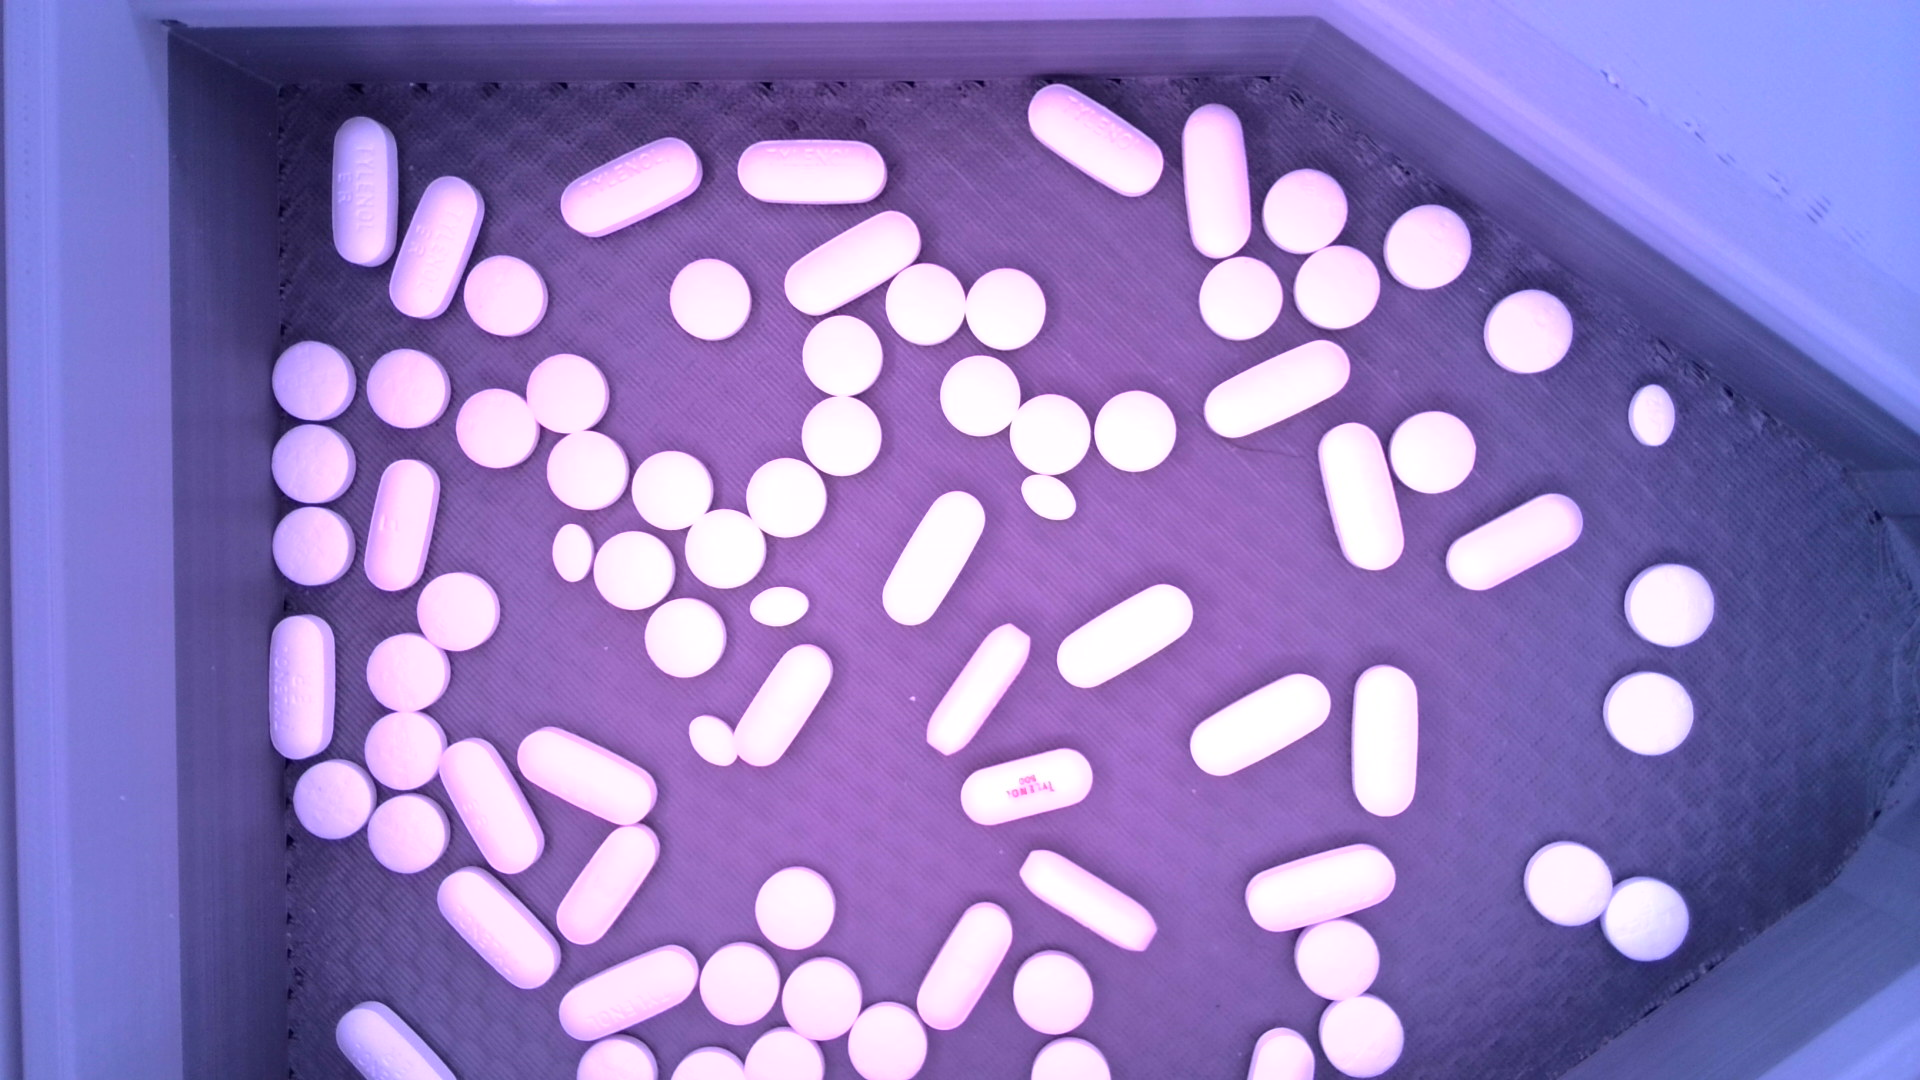

./test_images/middle_colorstandard-flourescent_led-brightness0.5_exposure1000_color-temp5200_left-right-linear-fade.jpg


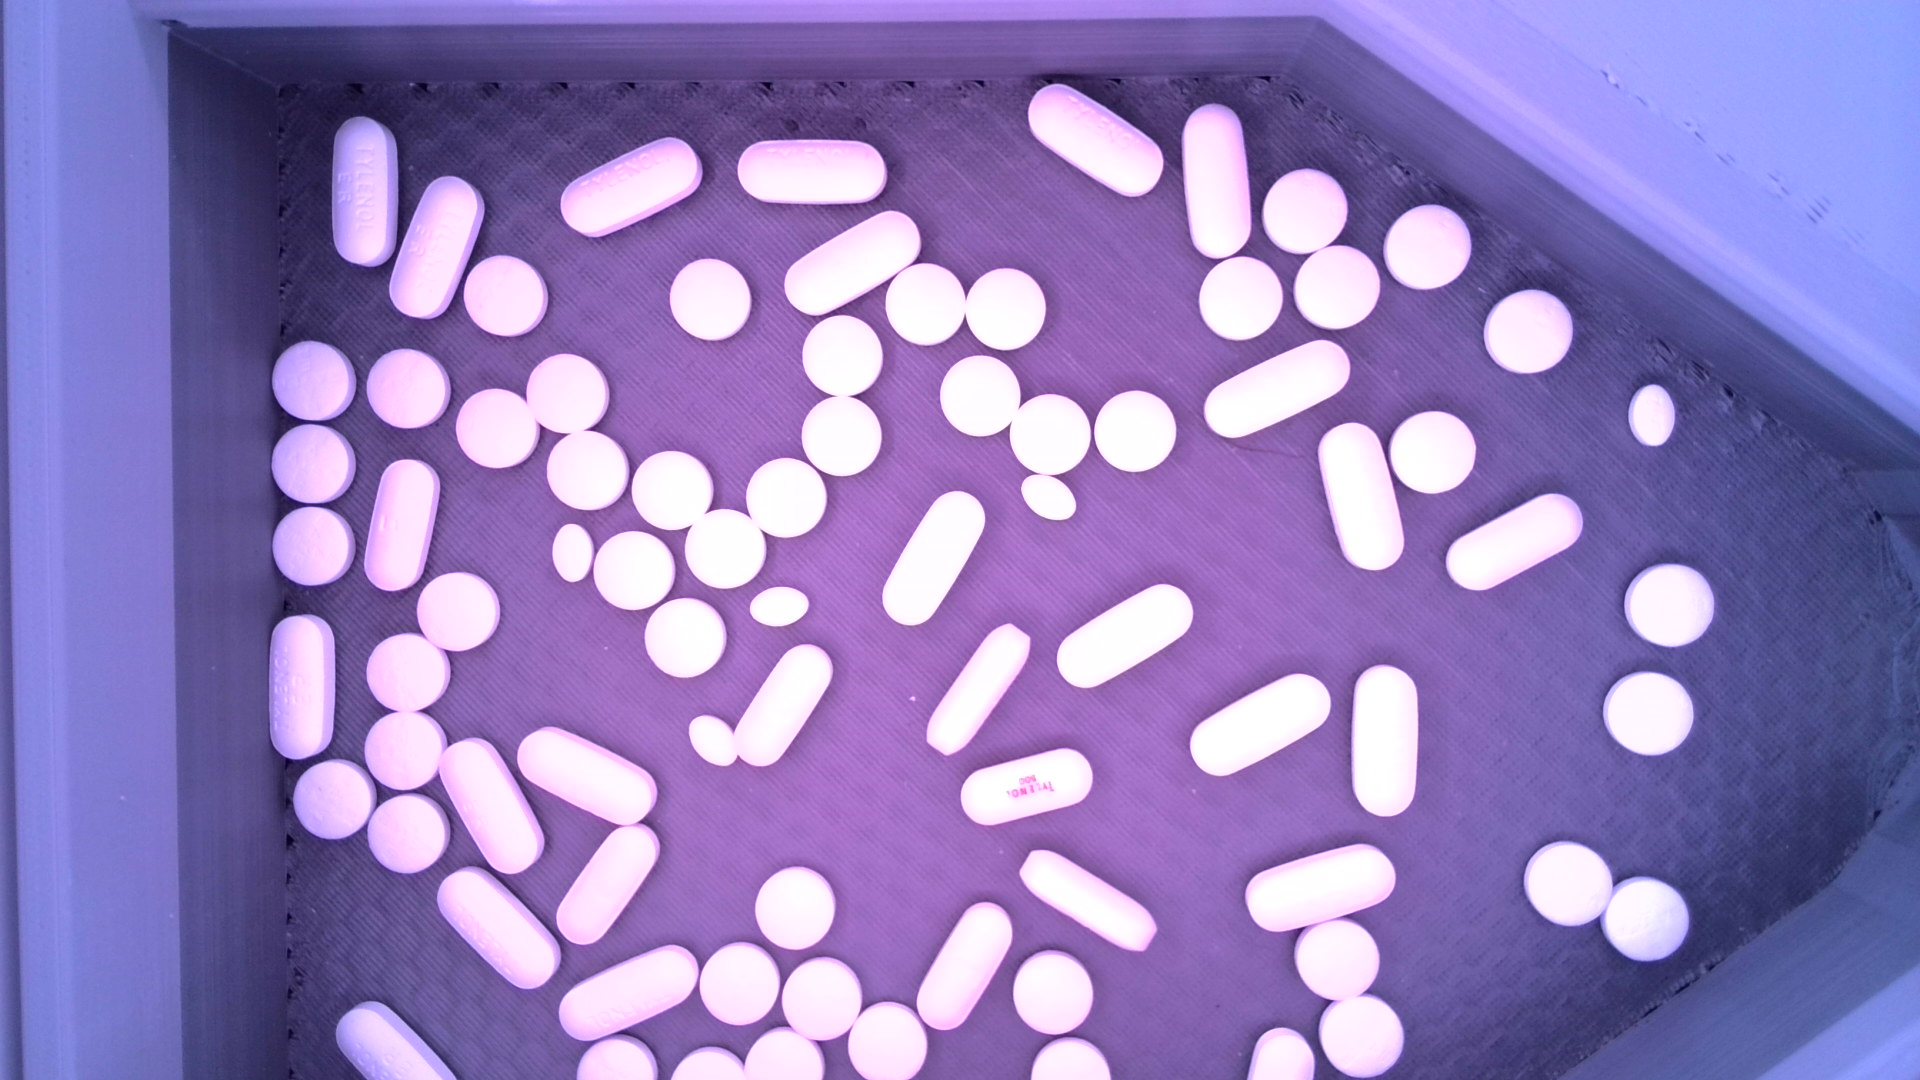

./test_images/bottom_no-ambient_colorwarm-flourescent_led-brightness0.75_exposure1000_color-temp2200_left-strip-linear-fade-back-dim.jpg


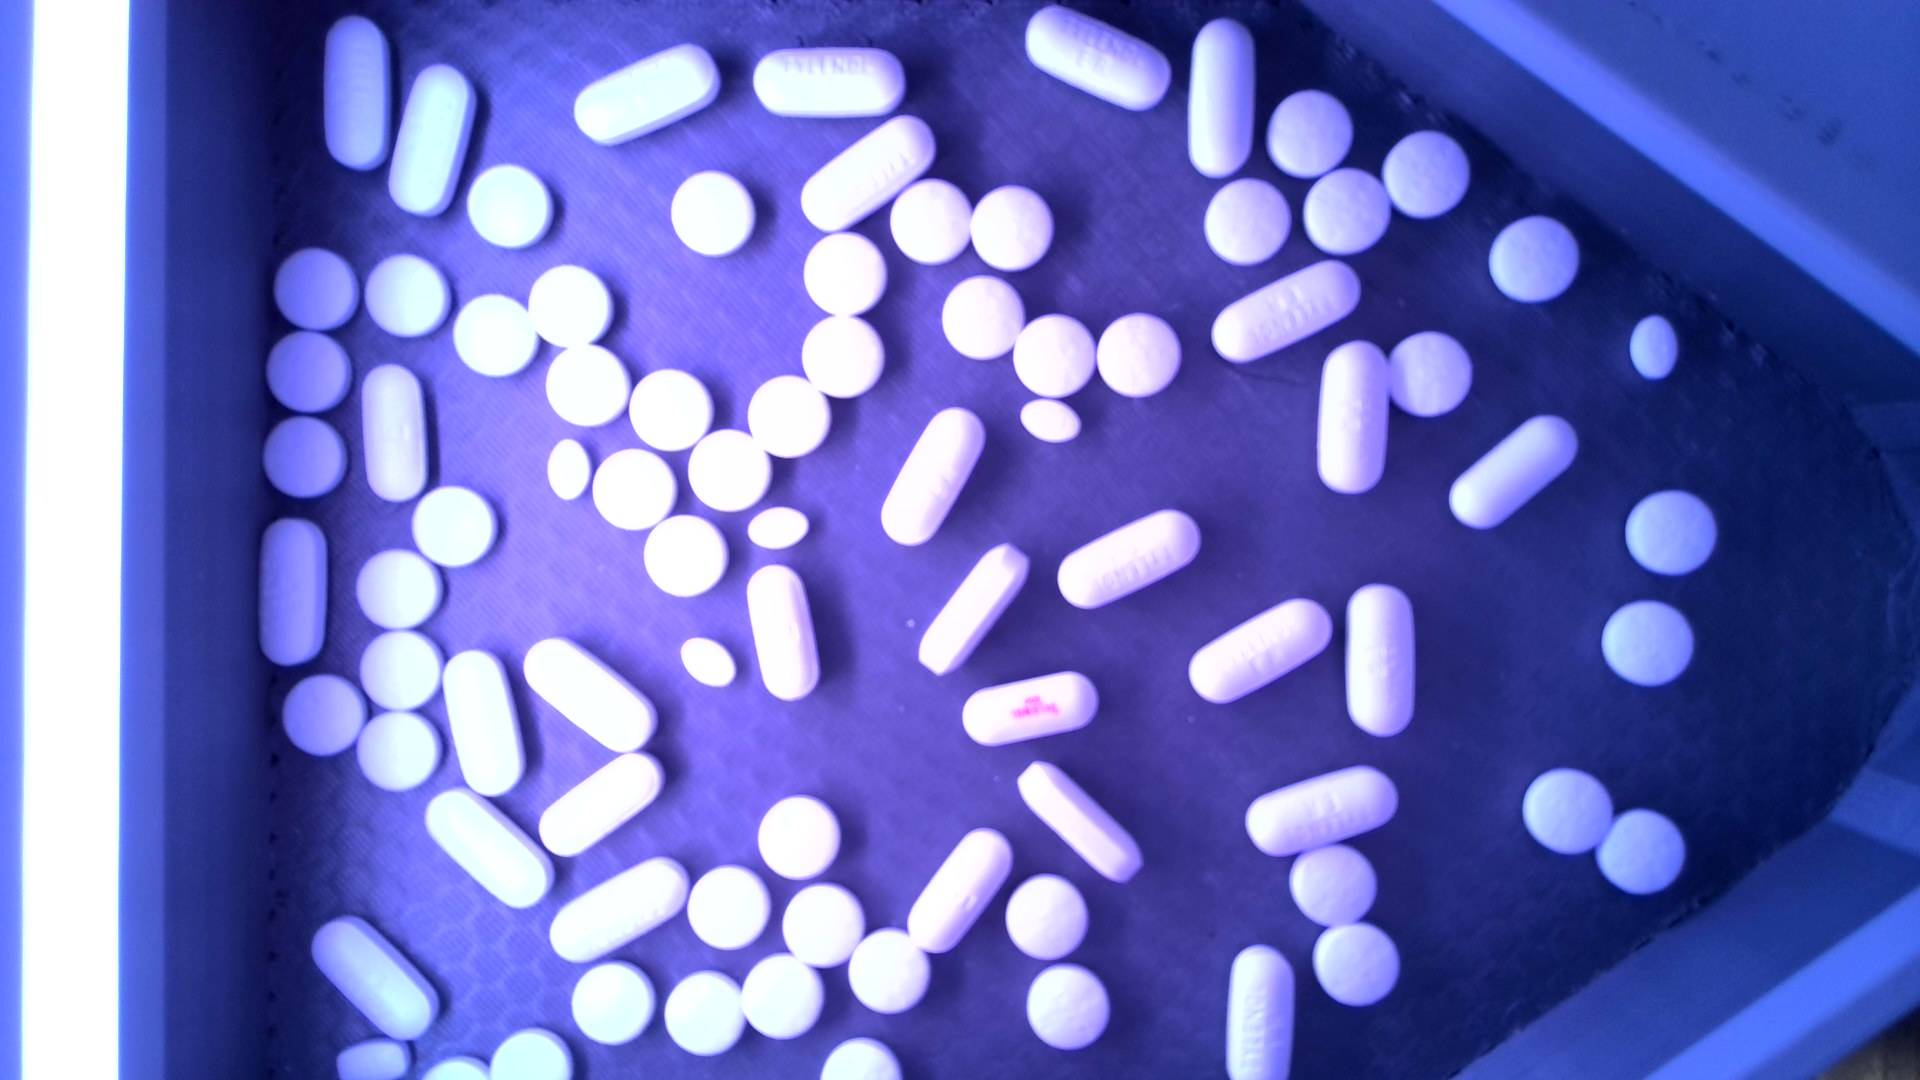

./test_images/bottom_no-ambient_coloryellow-4000k_led-brightness0.5_exposure750_color-tempauto_left-right-linear-fade.jpg


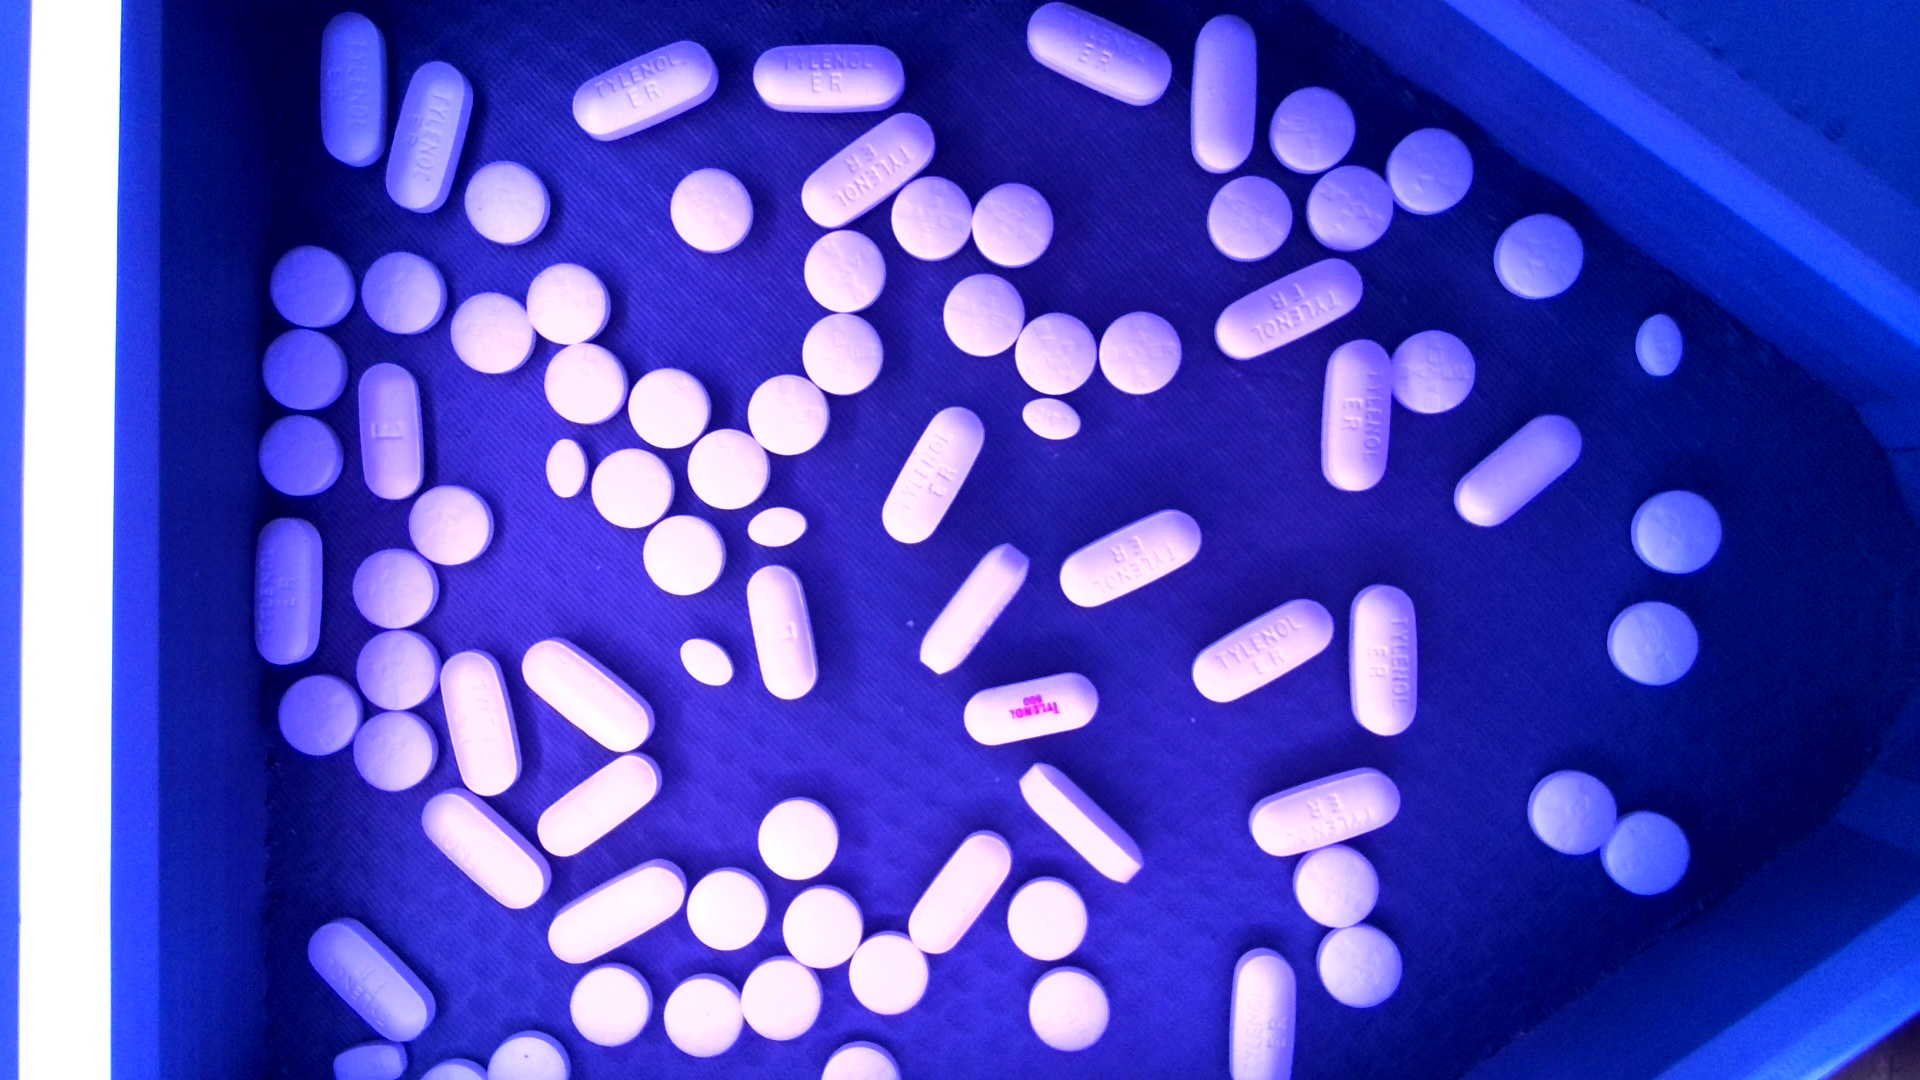

./test_images/middle_colorfull-spectrum-flourescent_led-brightness0.75_exposure500_color-temp2200_left-right-linear-fade.jpg


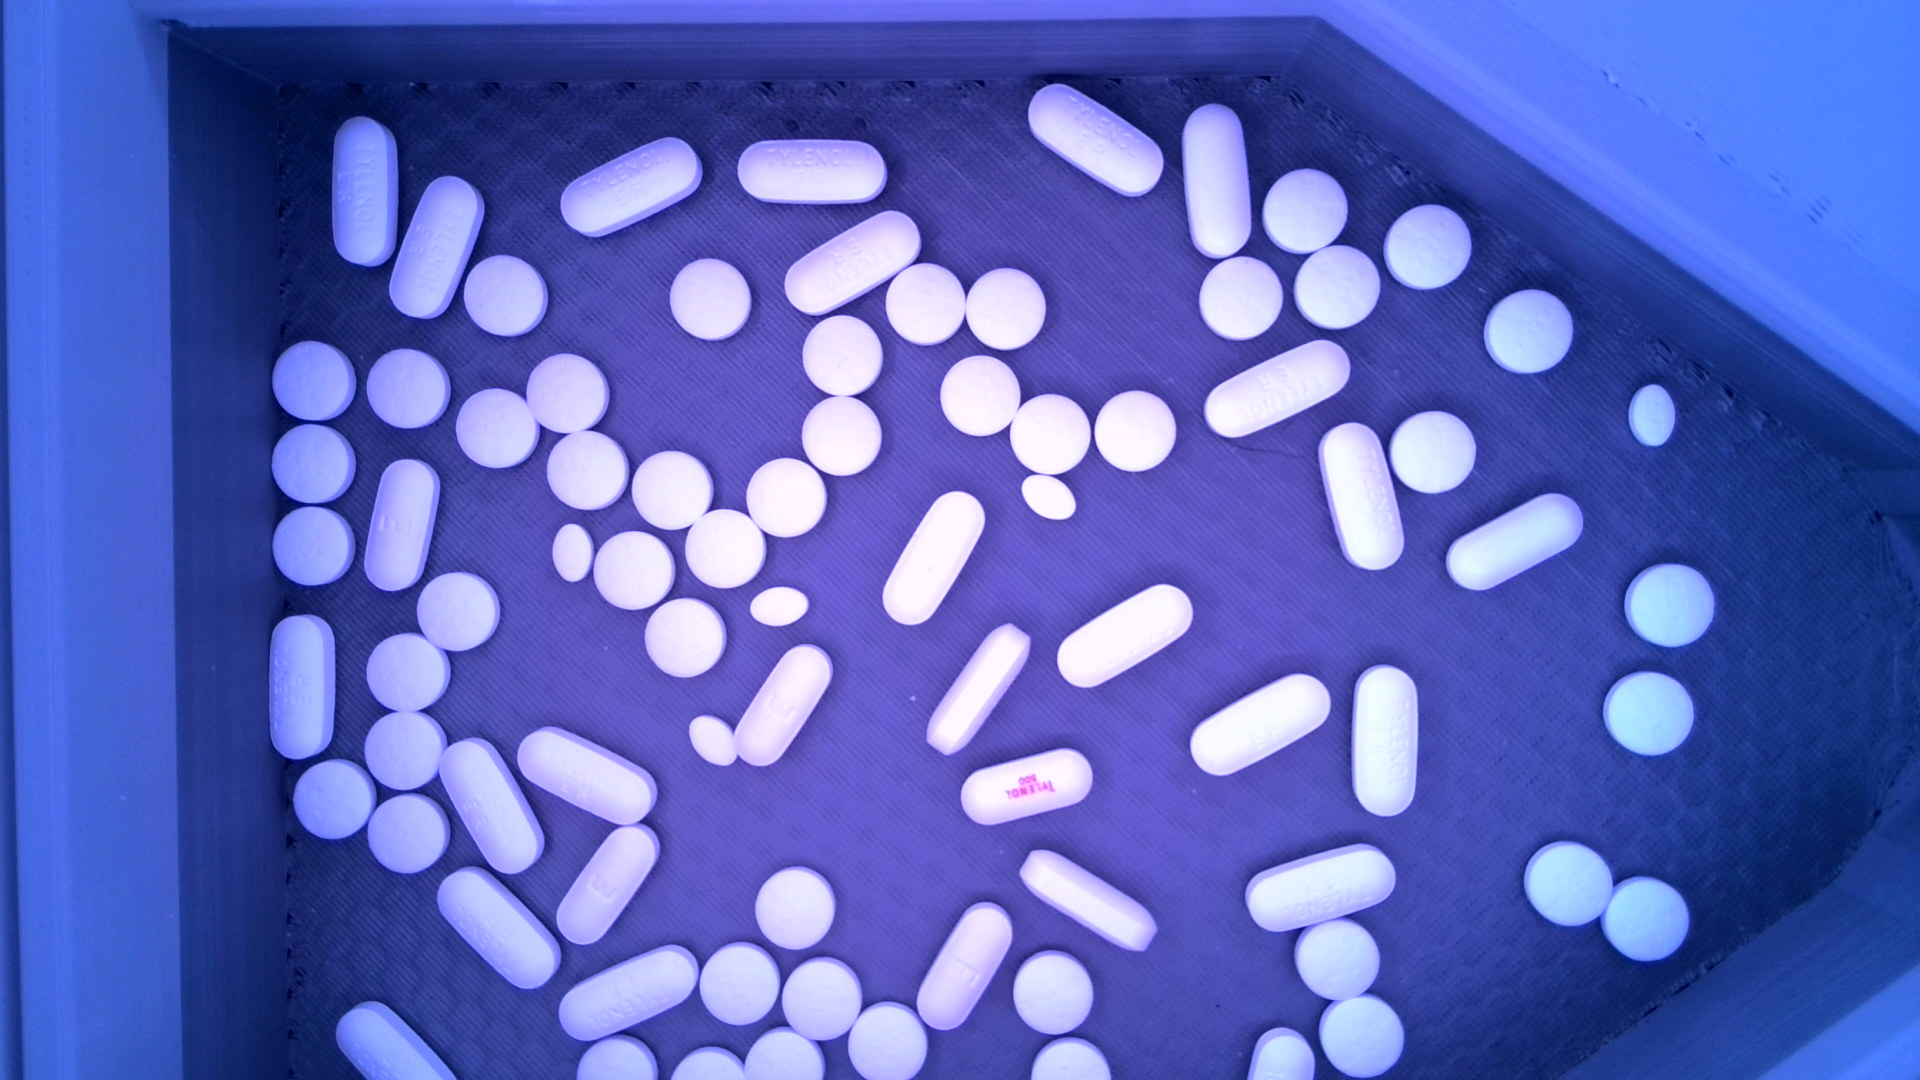

./test_images/middle_coloryellow-5000k_led-brightness0.75_exposure750_color-tempauto_full-strip.jpg


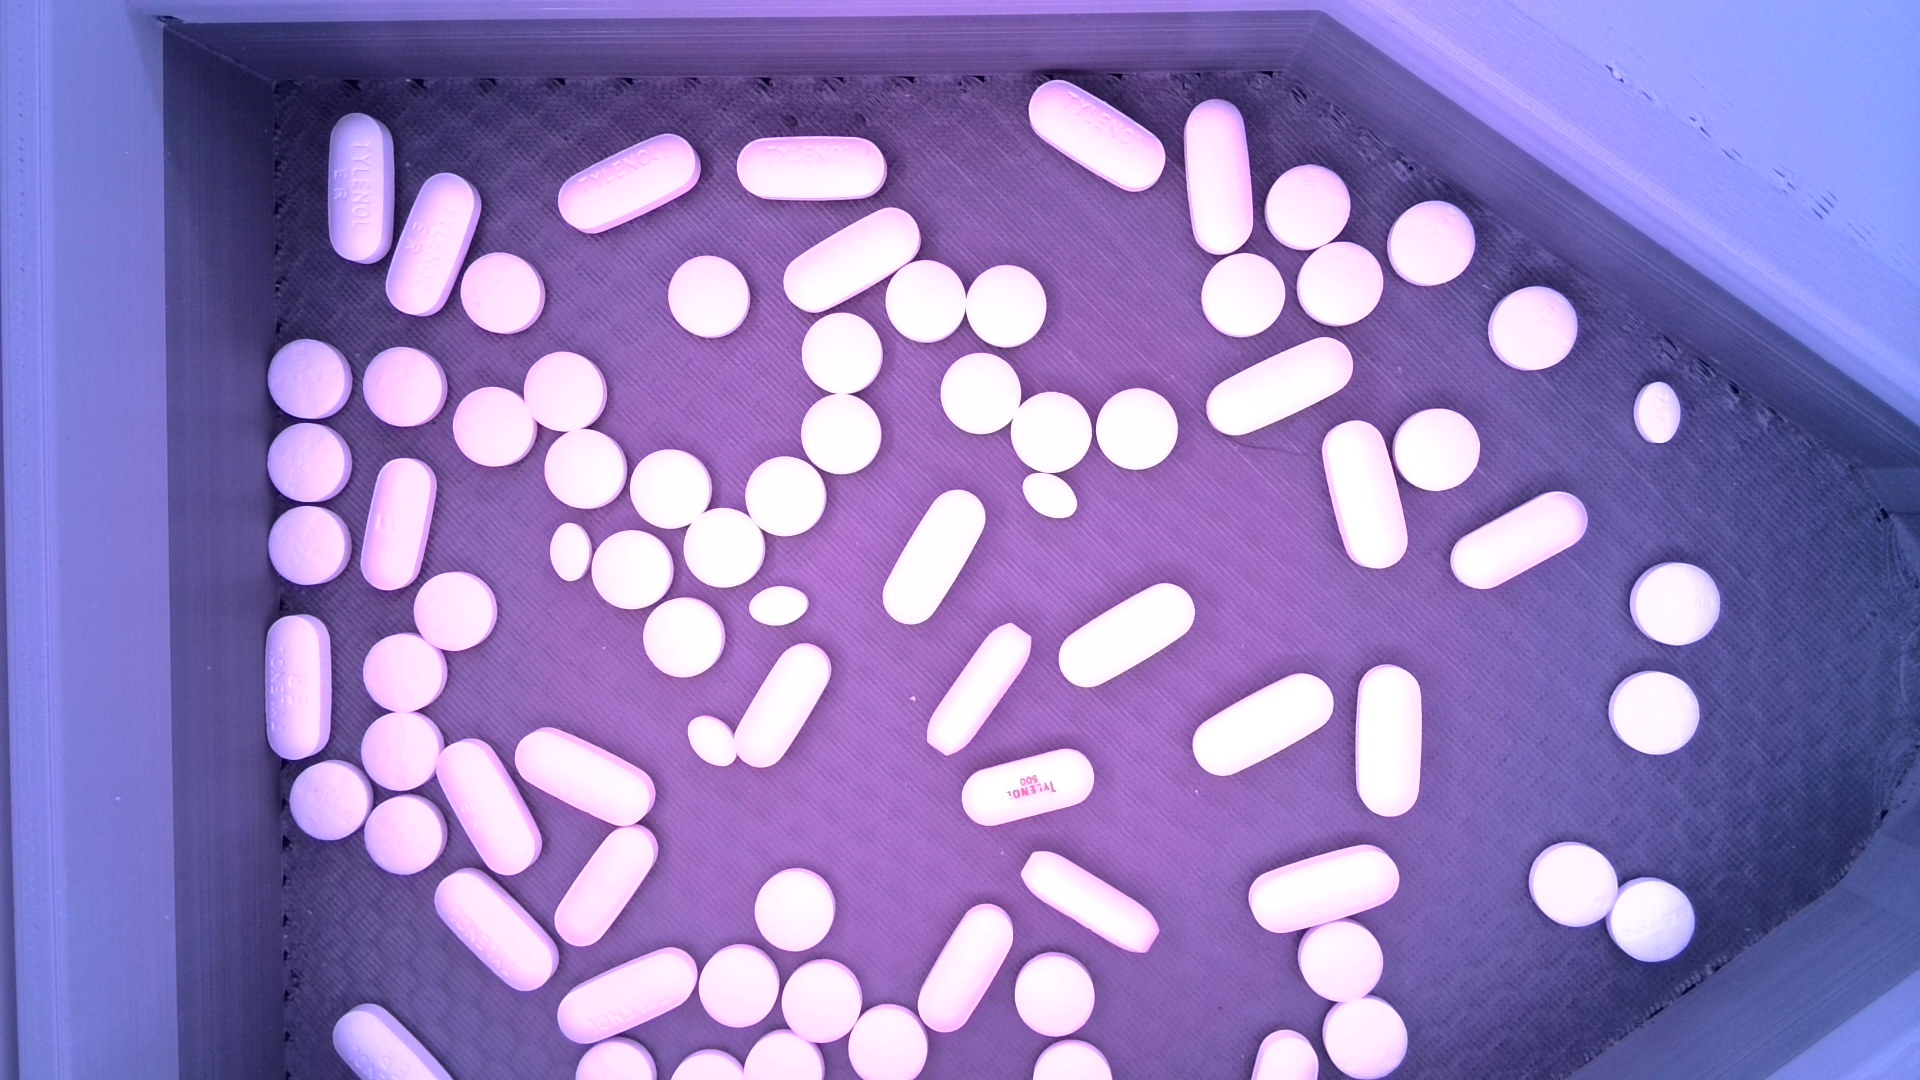

./test_images/middle_colorcarbon-arc_led-brightness1_exposure750_color-temp3200_left-strip-linear-fade.jpg


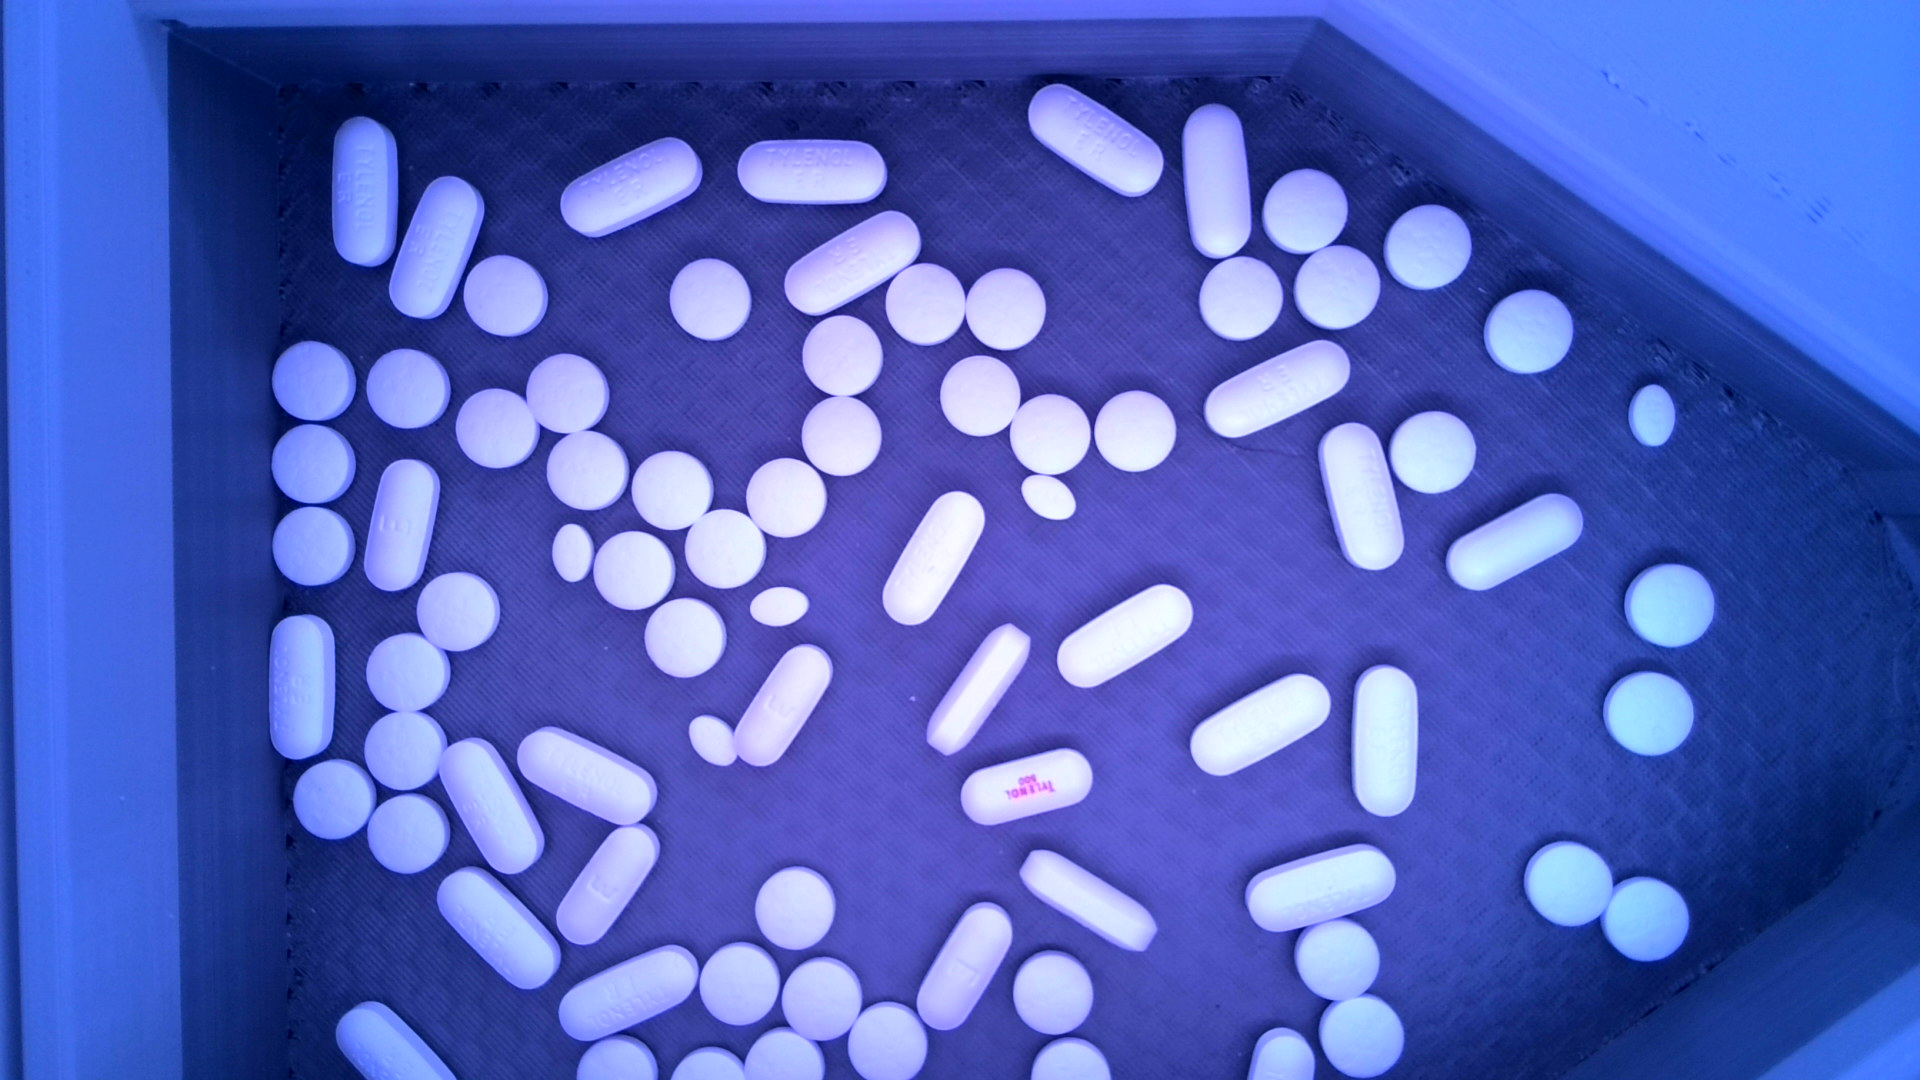

./test_images/middle_colorcarbon-arc_led-brightness0.75_exposure1000_color-temp6200_left-right-linear-fade.jpg


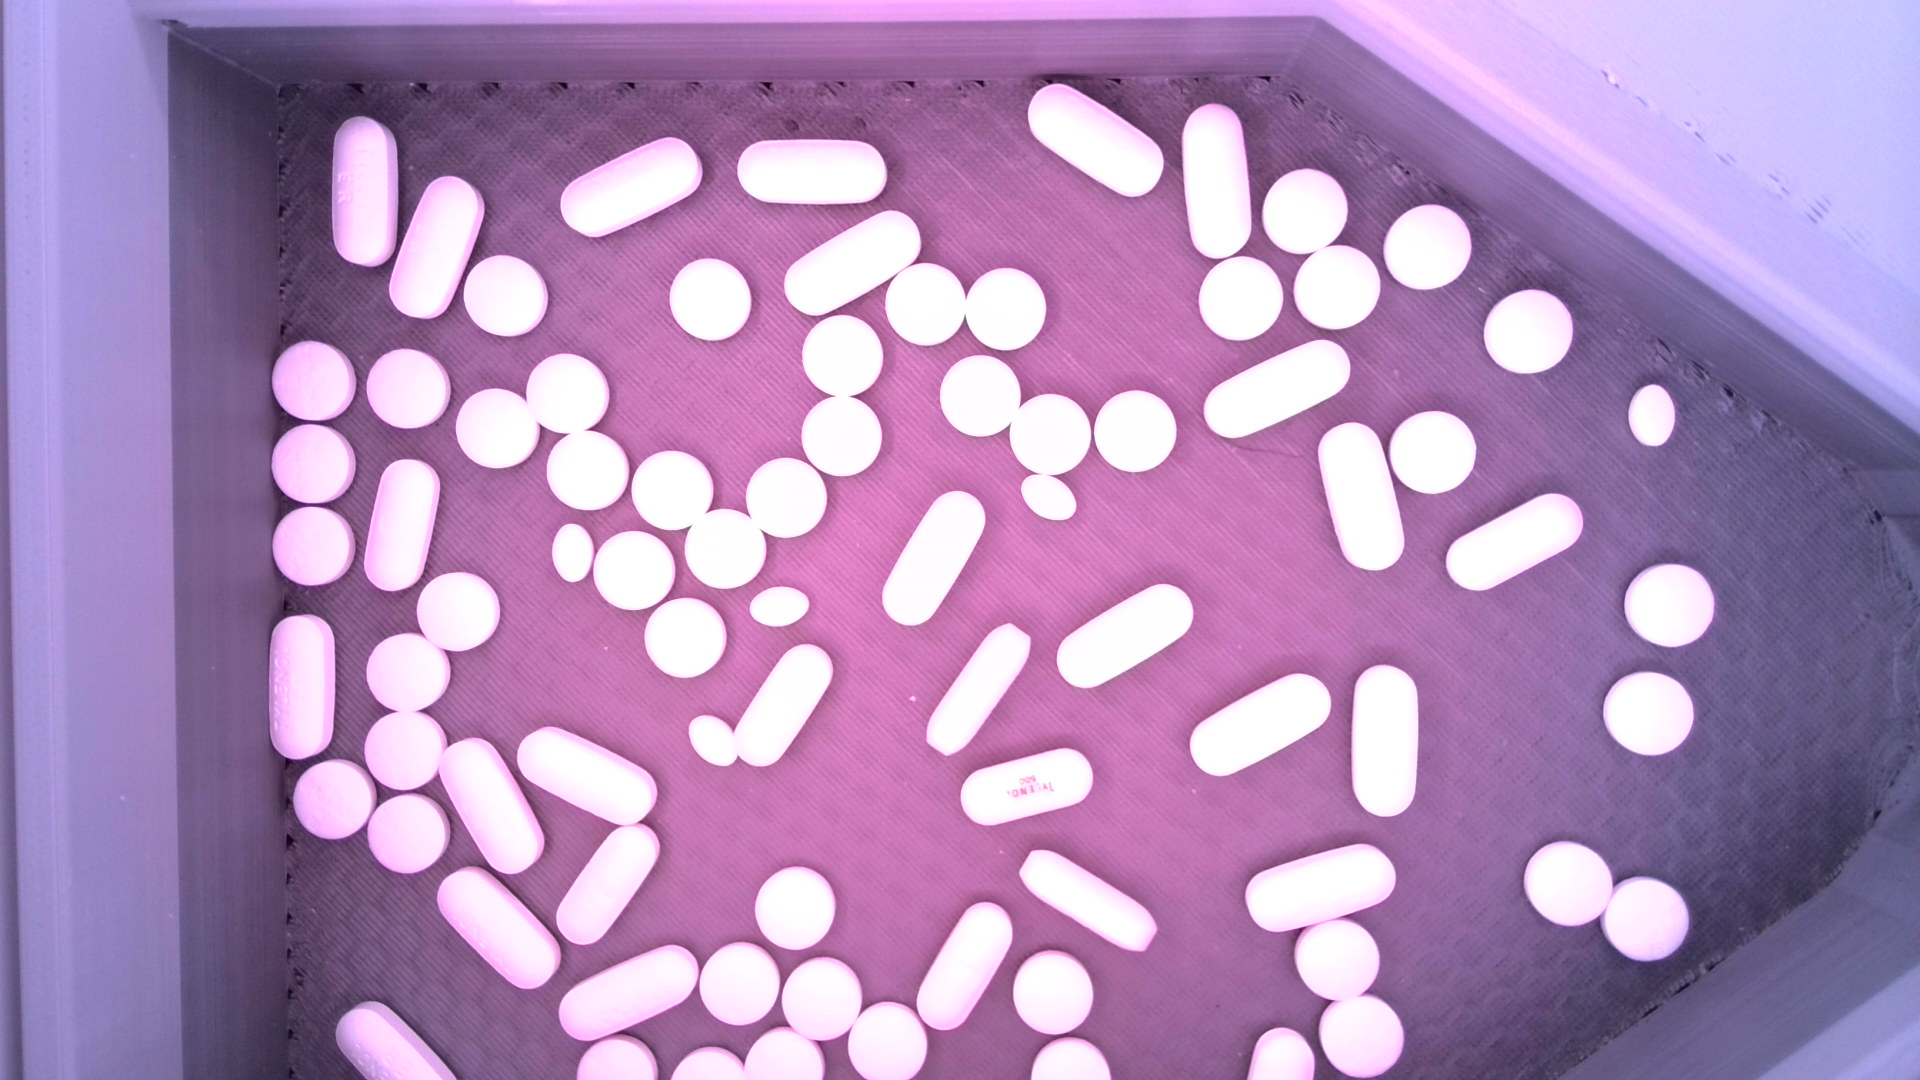

./test_images/bottom_no-ambient_colorcarbon-arc_led-brightness0.5_exposure1000_color-temp3200_left-right-linear-fade.jpg


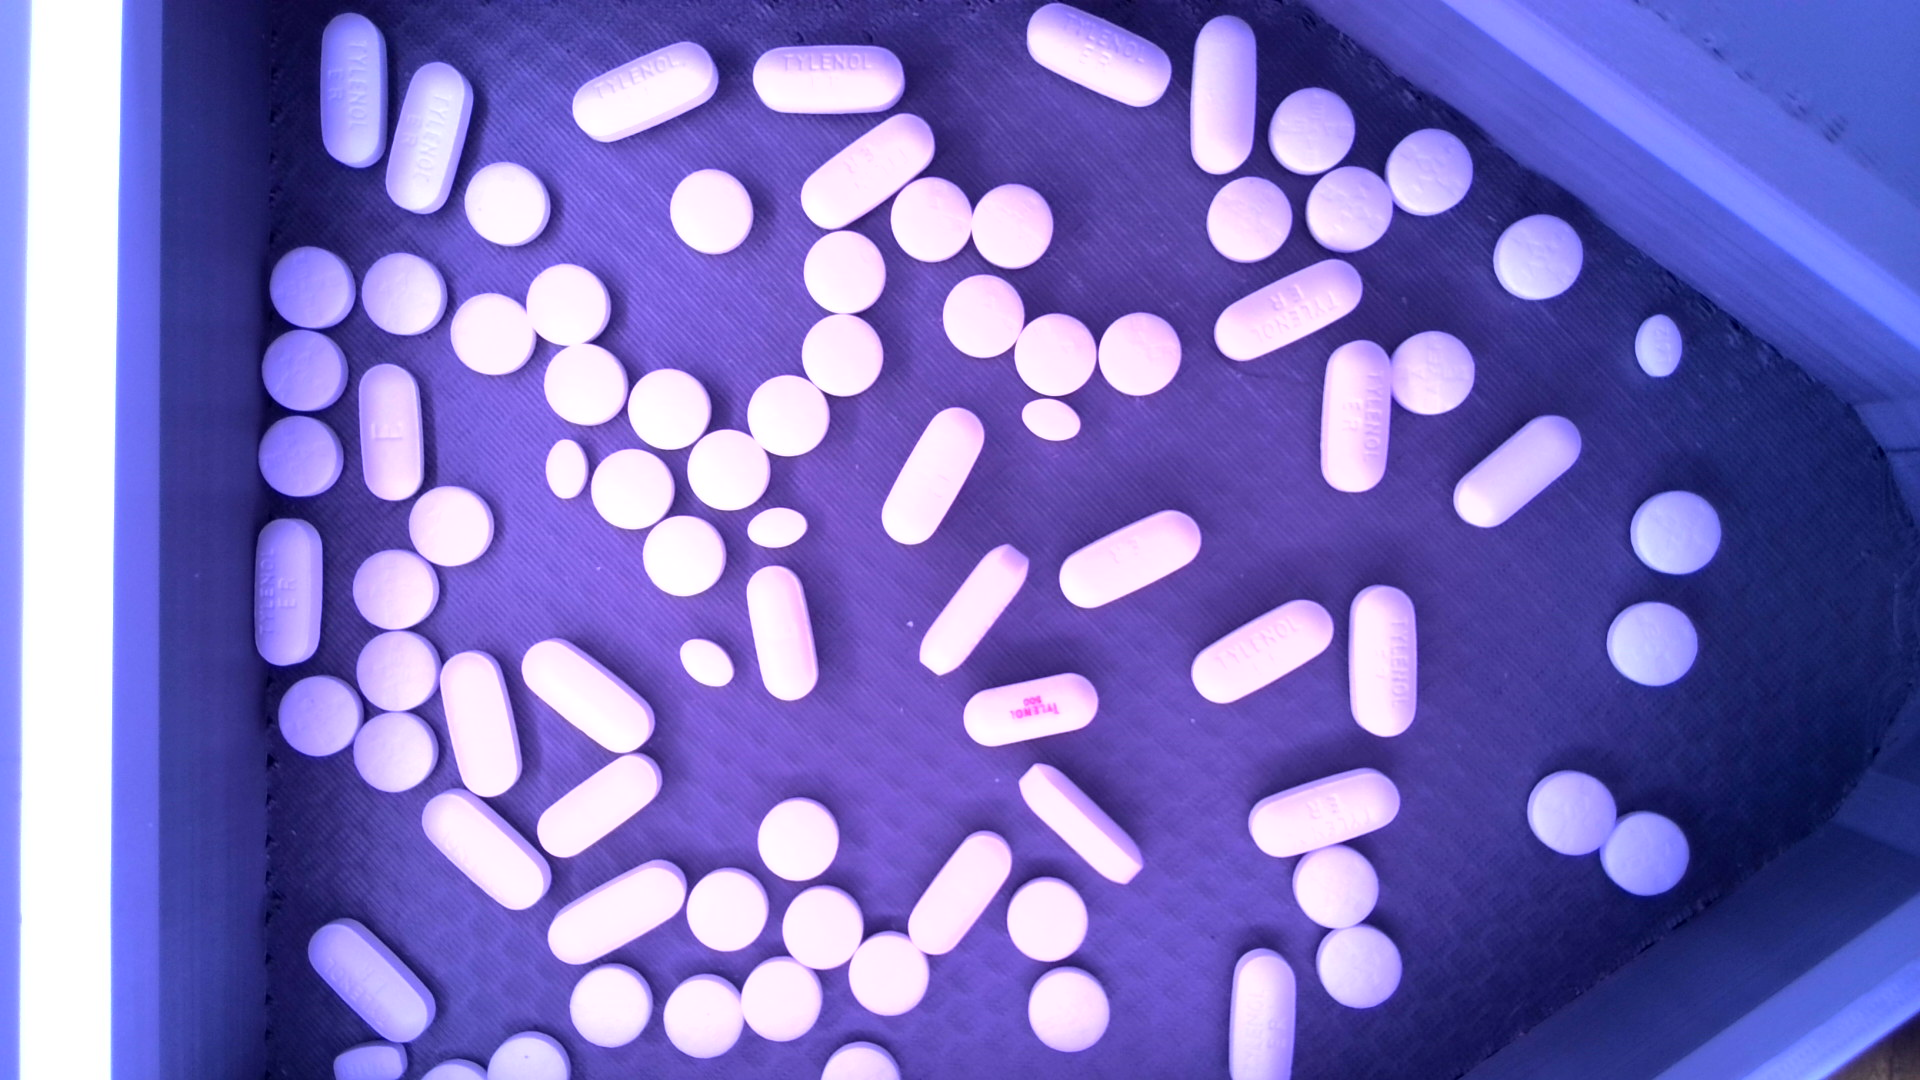

./test_images/bottom_no-ambient_colorwarm-flourescent_led-brightness0.75_exposure1000_color-temp3200_left-strip-linear-fade.jpg


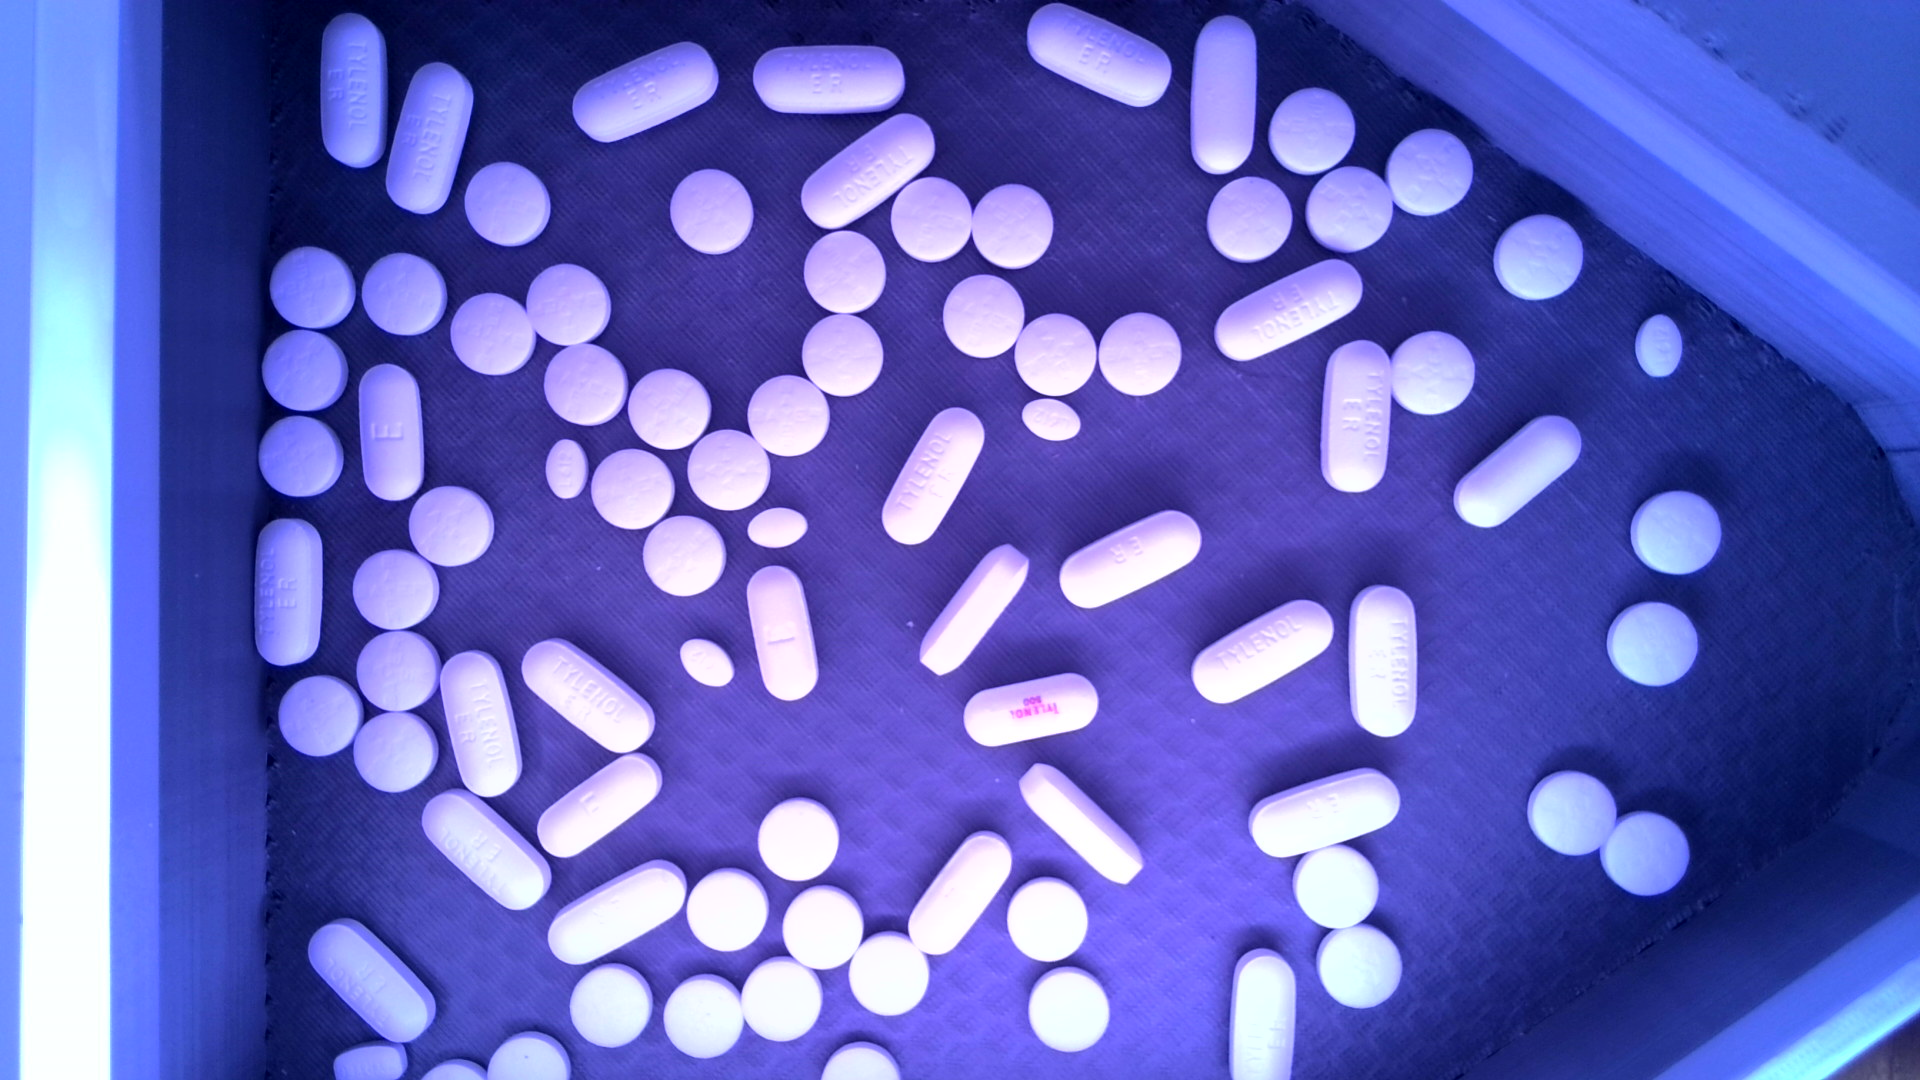

./test_images/bottom_no-ambient_coloryellow-5500k_led-brightness1_exposure500_color-temp4600_left-right-linear-fade.jpg


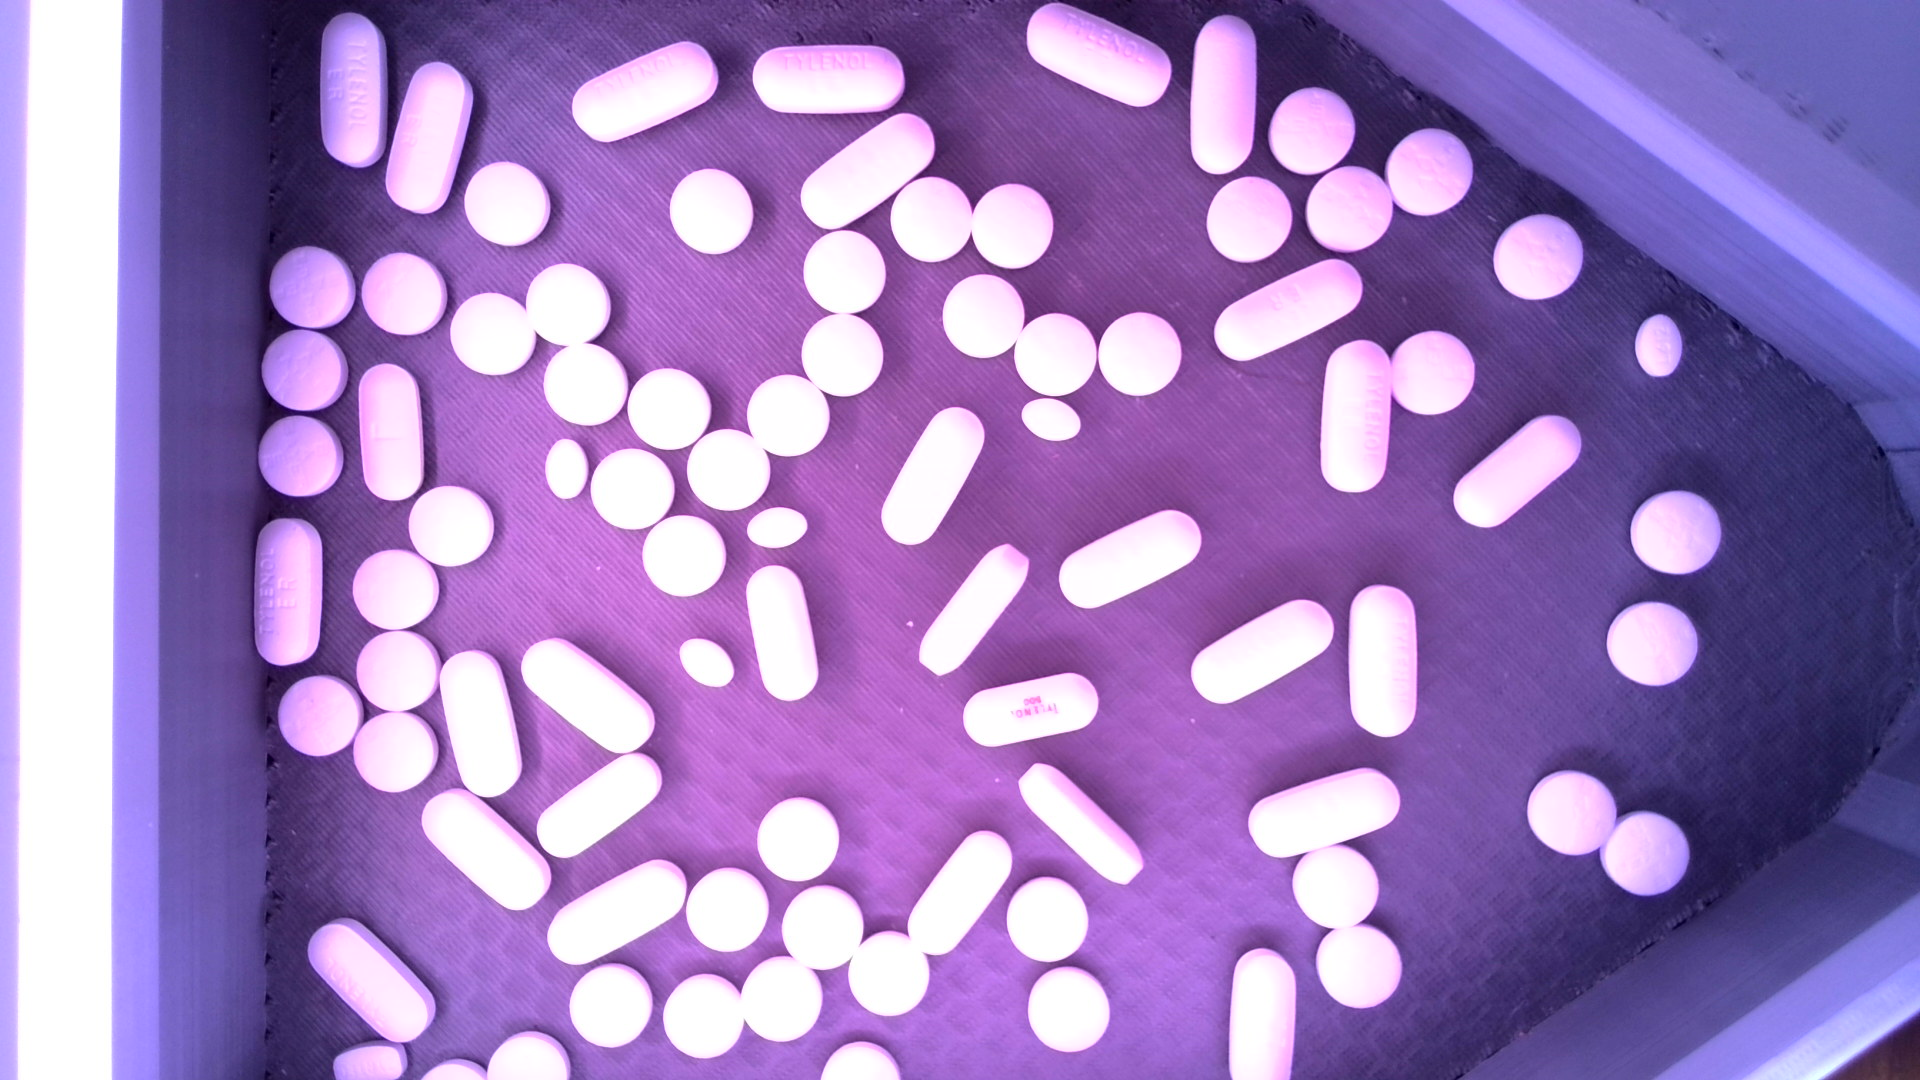

./test_images/bottom_no-ambient_colorfull-spectrum-flourescent_led-brightness0.5_exposure750_color-temp2200_left-right-linear-fade.jpg


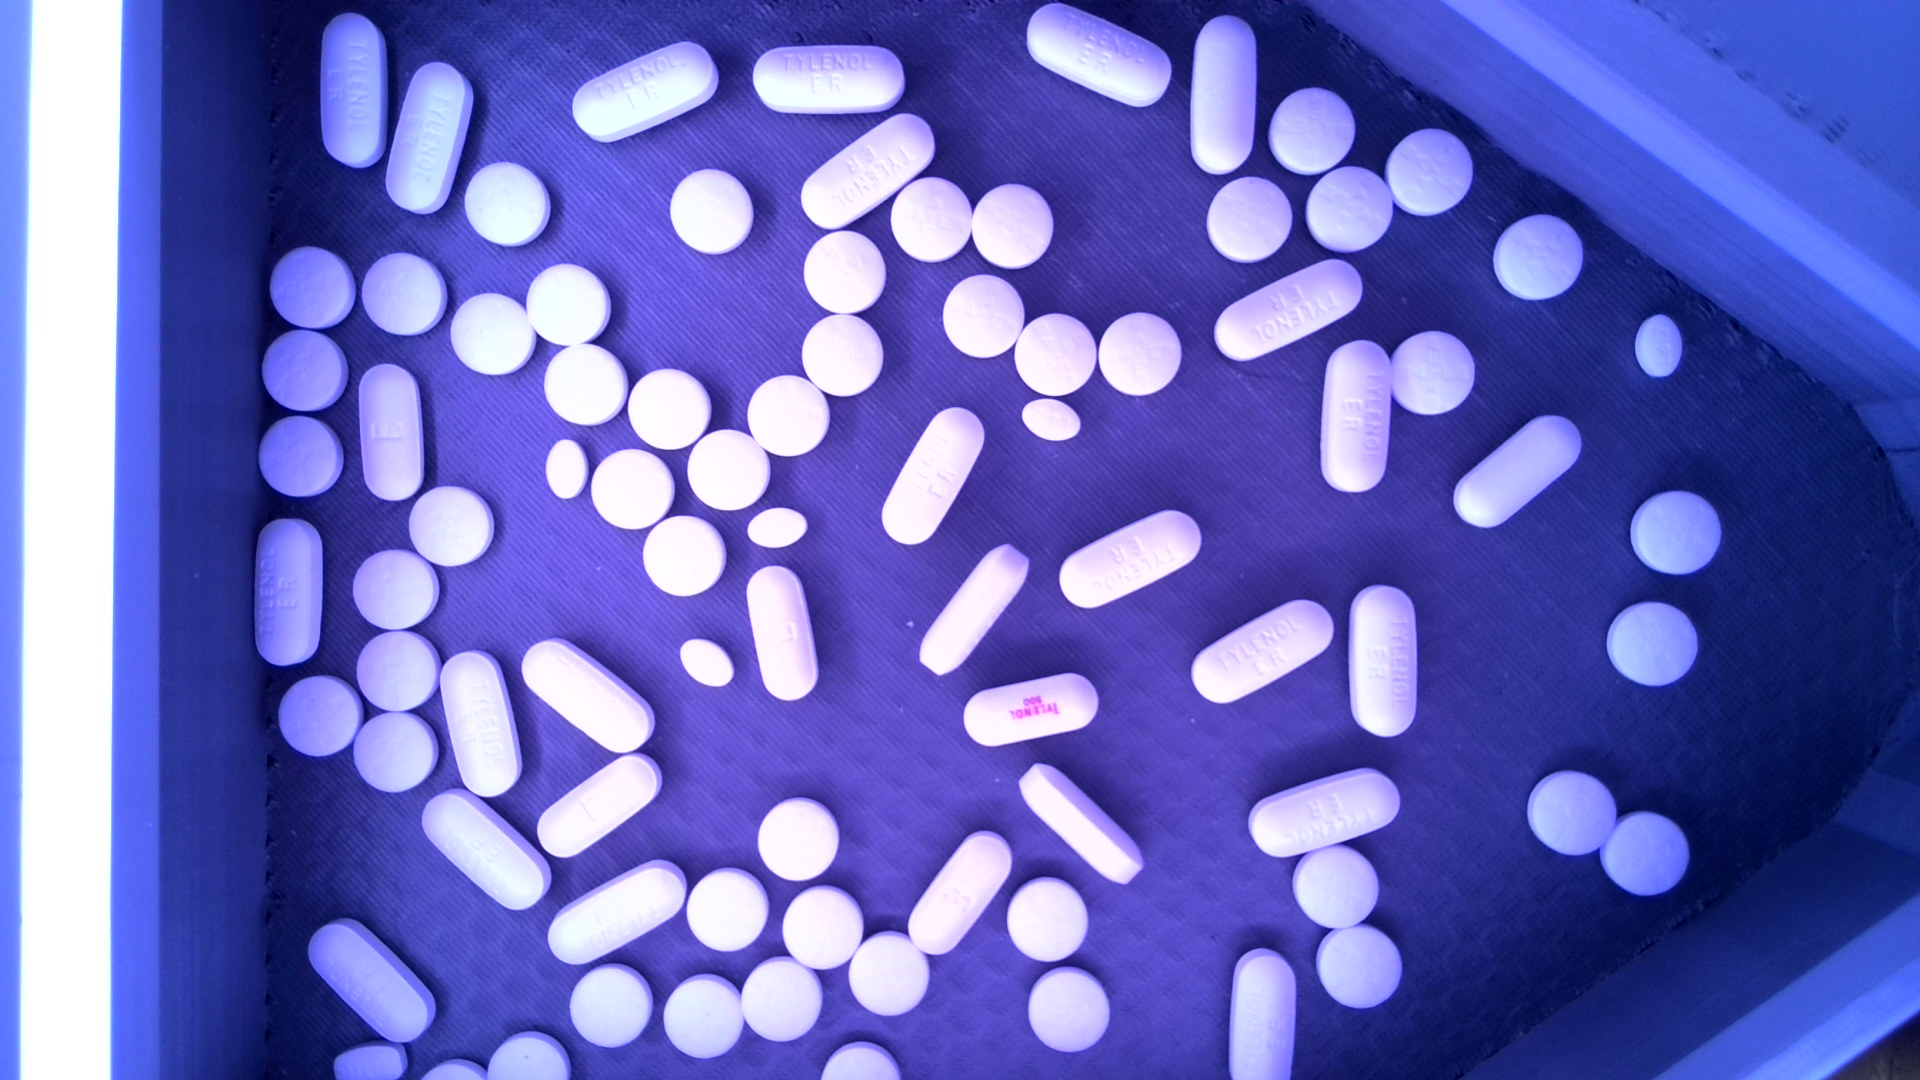

./test_images/middle_colorwhite_led-brightness1_exposure2000_color-temp5200_right-strip-linear-fade-back-dim.jpg


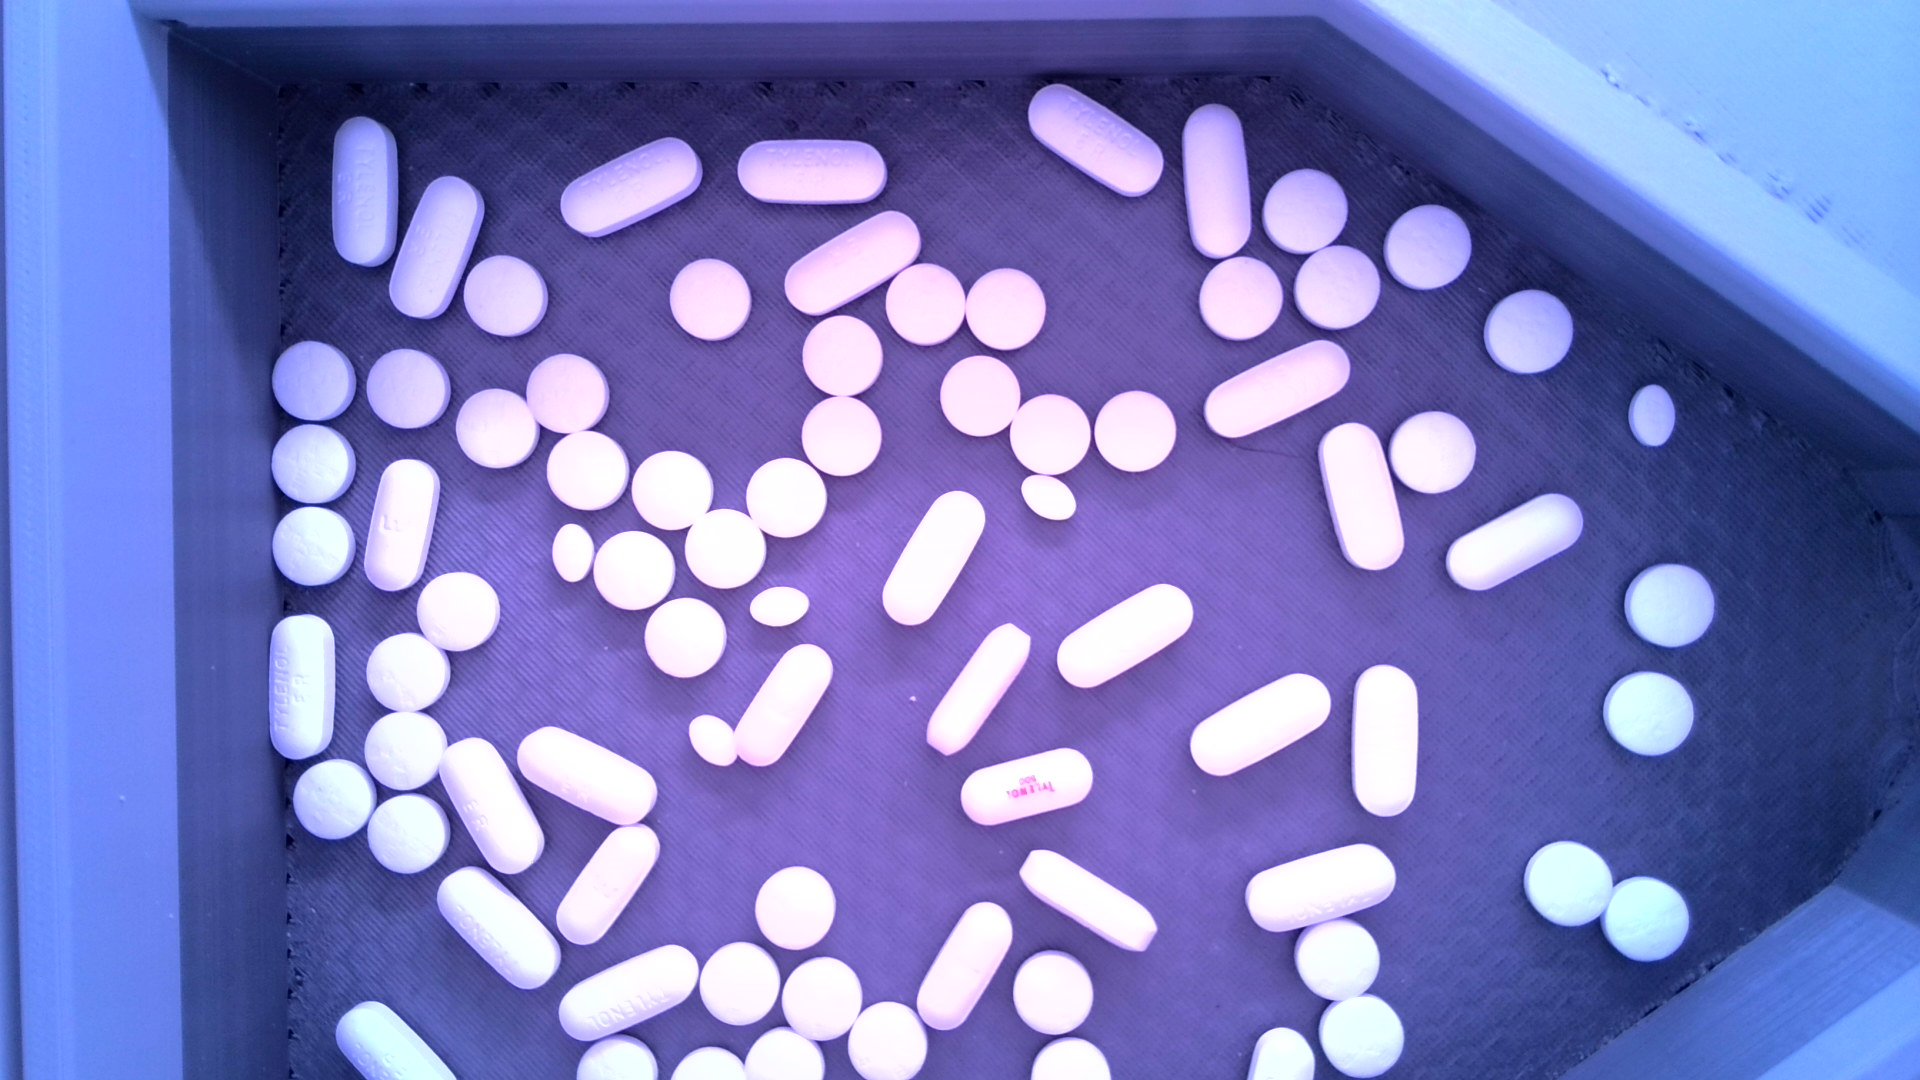

./test_images/middle_colorstandard-flourescent_led-brightness0.75_exposure1000_color-temp3200_left-strip-linear-fade.jpg


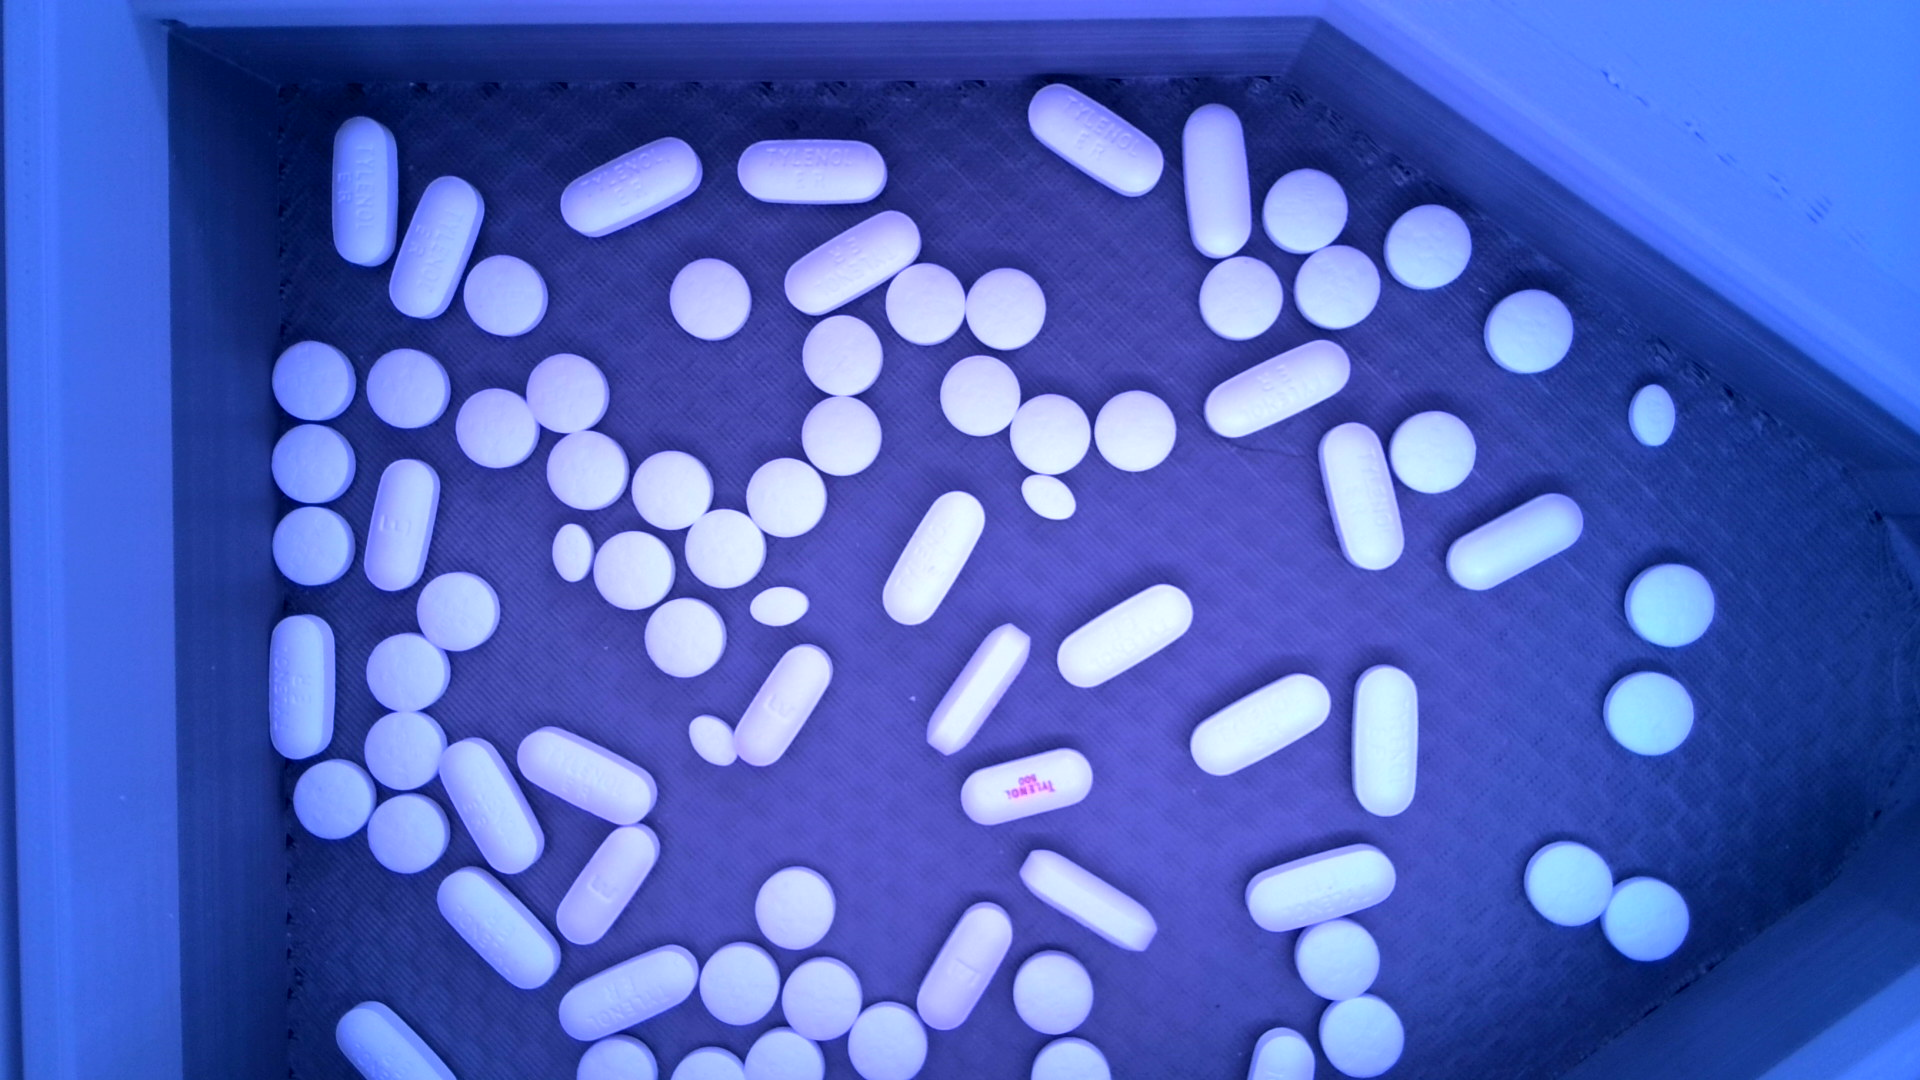

./test_images/middle_coloryellow-5500k_led-brightness1_exposure2000_color-temp4200_right-strip-linear-fade-back-dim.jpg


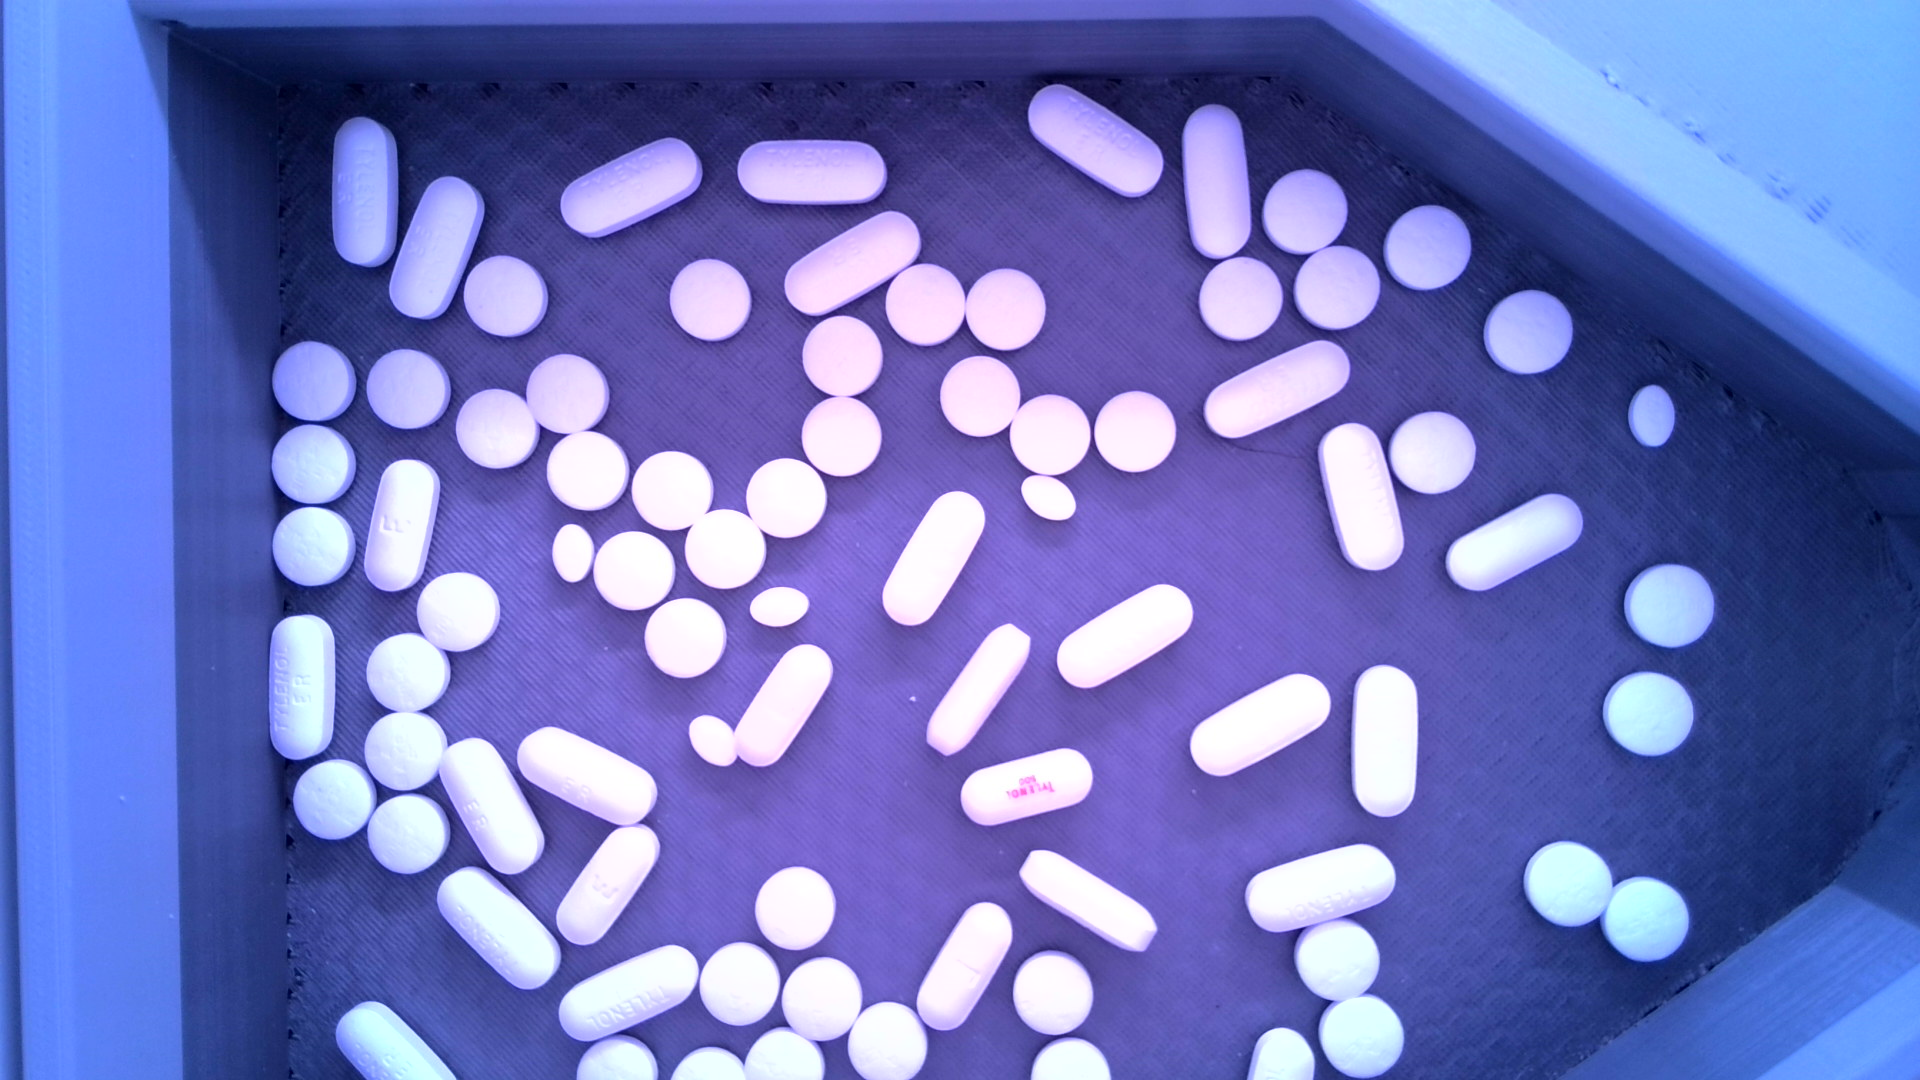

./test_images/middle_colorcarbon-arc_led-brightness0.75_exposure750_color-temp5200_left-right-linear-fade.jpg


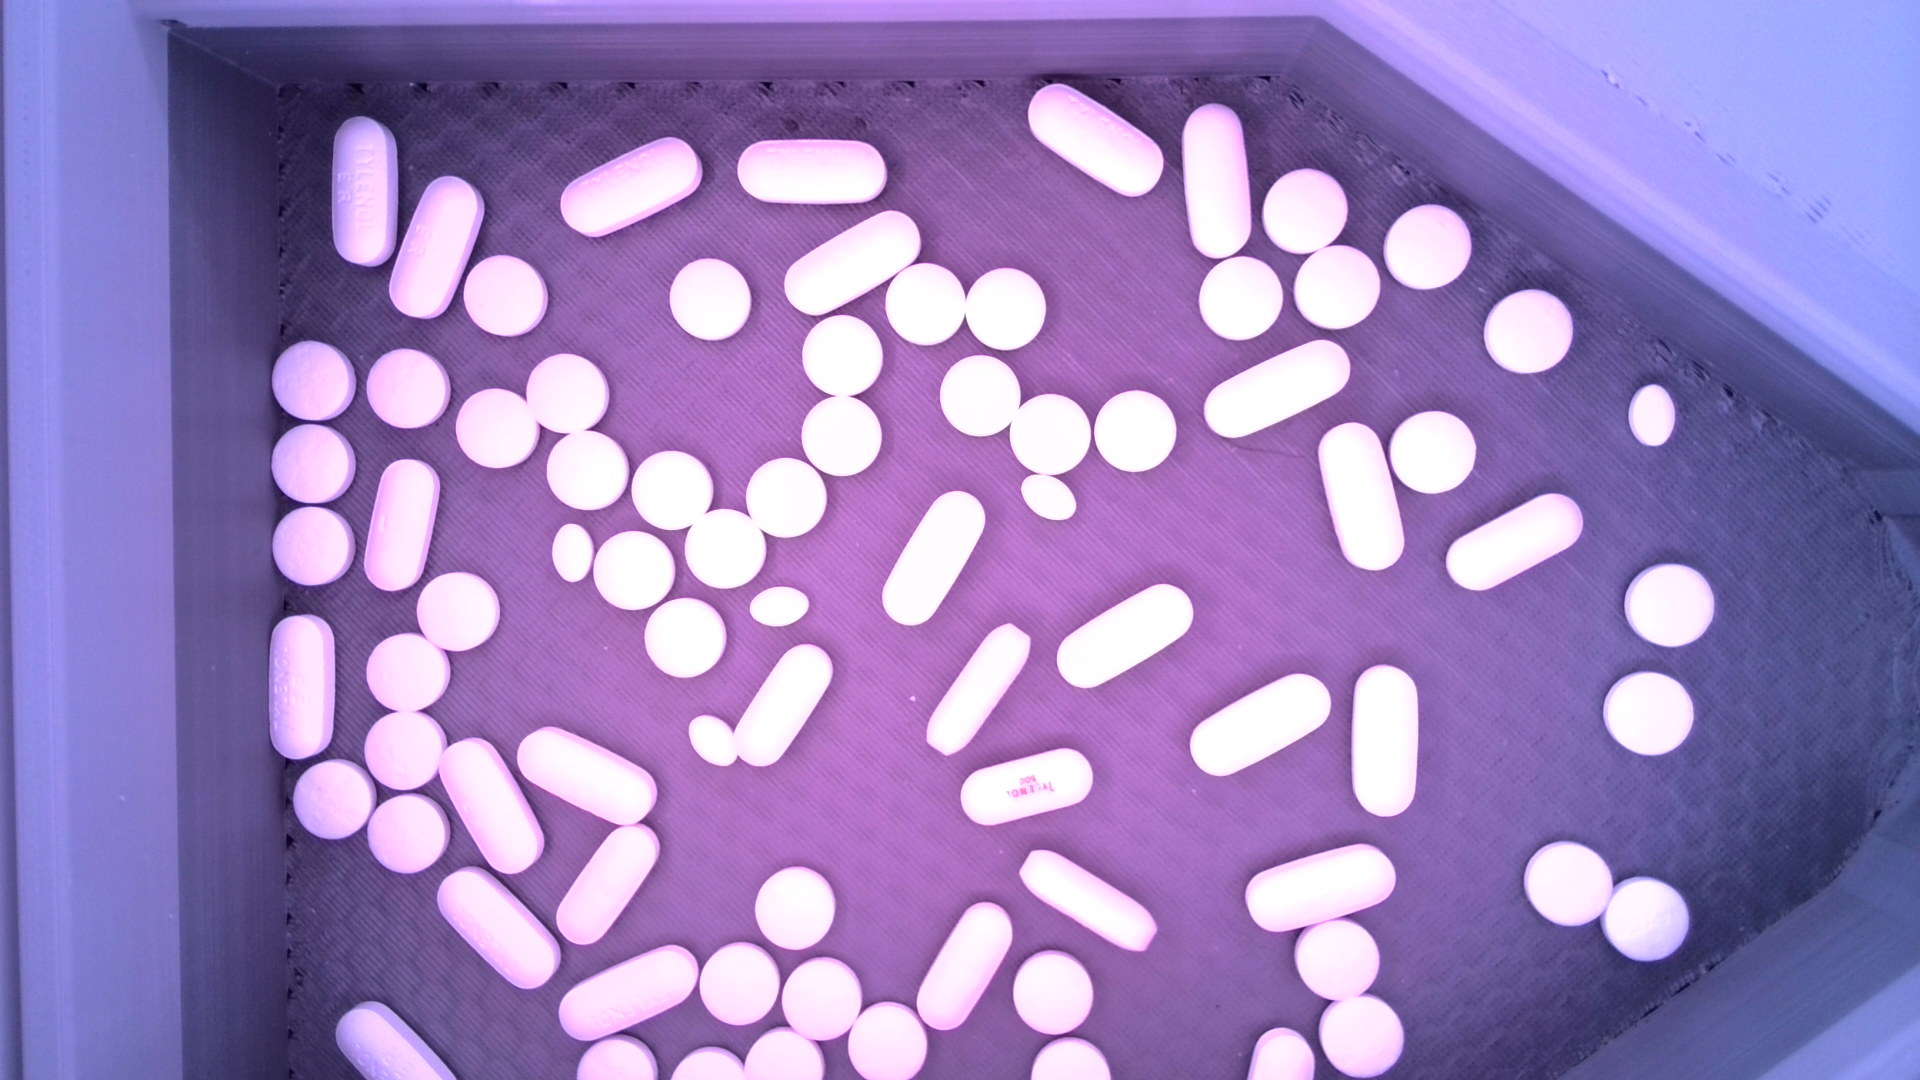

./test_images/bottom_no-ambient_colorstandard-flourescent_led-brightness0.5_exposure750_color-temp3200_left-right-linear-fade.jpg


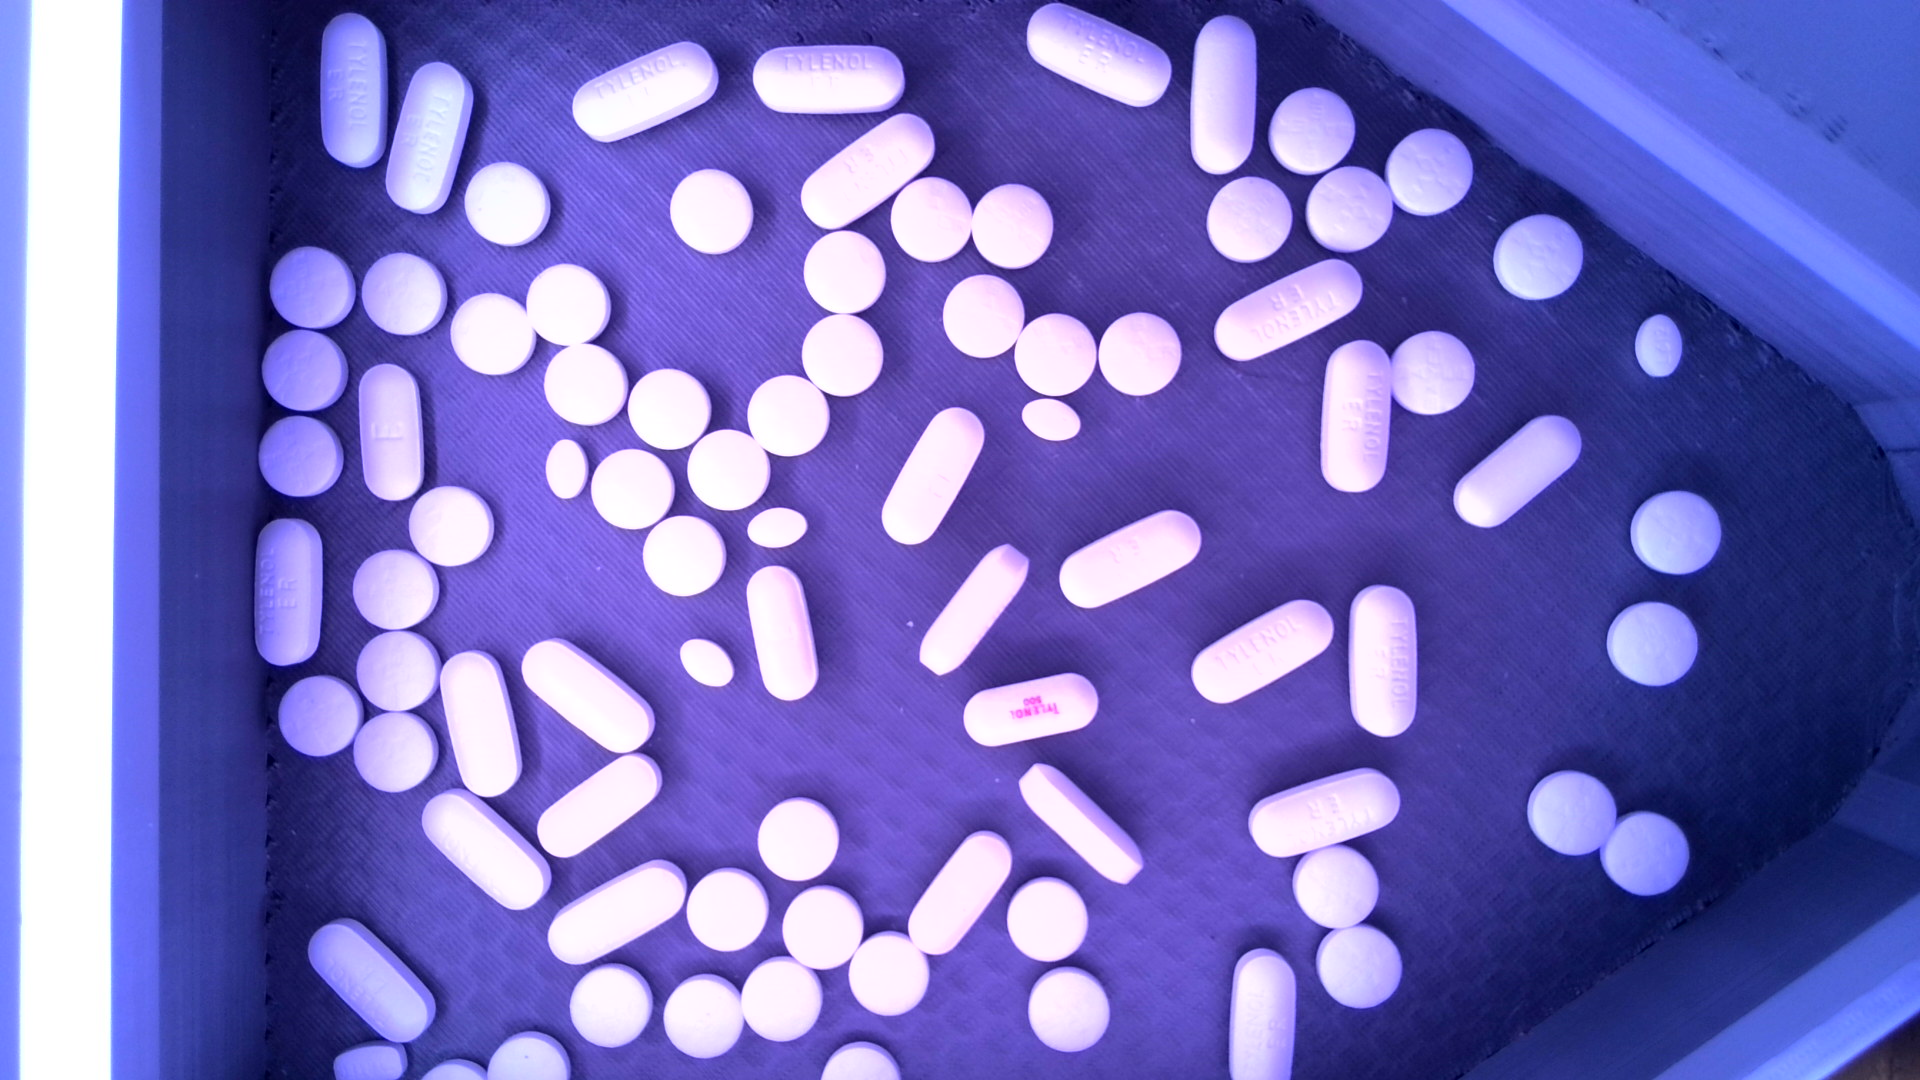

./test_images/bottom_no-ambient_colorhalogen_led-brightness1_exposure750_color-temp3200_left-strip-linear-fade.jpg


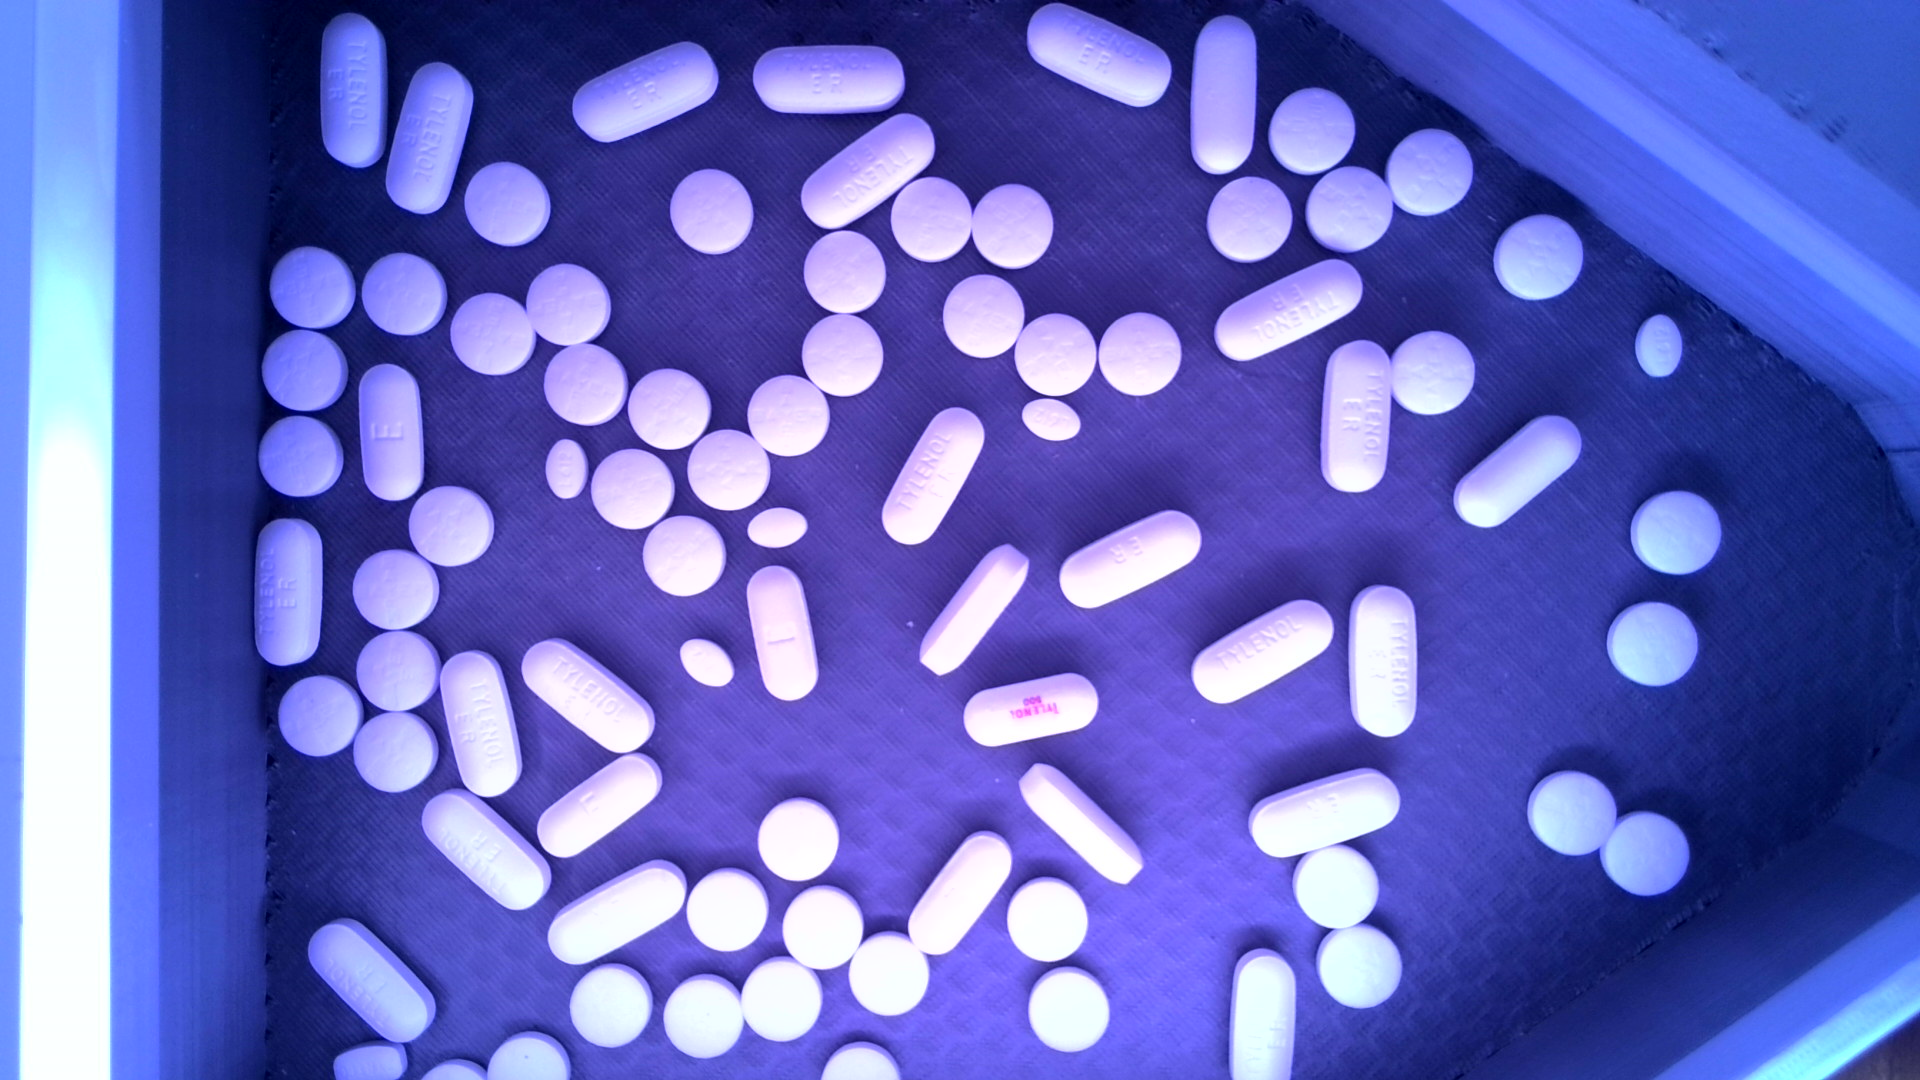

In [156]:
imgs = get_images_matching_criteria(df, "./test_images/", criteria=df["value_mean"]>190, sort_by="value_mean", count=20, ascending=True)
display_images(imgs)

In [157]:
imgs = get_images_matching_criteria(df, "./test_images/", criteria=df["value_mean"]>190, sort_by="value_mean", ascending=True)
print(len(imgs))
create_zip_from_paths(imgs, "avg_value_greater_than_190.zip")

506


The "technical" model seems to always select the `yellow` and `off` colors as the best images. The `yellow` ones aren't really what we want, because it misrepresents the color of pills. `Off` is also obviously not what we want, because you can't see anything.

It also chooses the way over exposed ones with `exposure = 2000` and `led-brightness = [1, 0.75]`. 

So we remove those below.

In [ ]:
crit = join_and([~has_yellow, ~is_off, ~(brightness_eq_1 & exposure2000), ~(brightness_eq_75 & exposure2000), ~(brightness_eq_1 & full_strip)])
cleaned = df[crit]
cleaned.nlargest(20, "score")

In [ ]:
open_images_matching_criteria(cleaned, count=20)

In [ ]:
display_images_matching_criteria(df, criteria=exposure2000)

So basically all the images with `exposure = 2000` are overexposed except when only the right strip is illuminated. Lets choose only those and take a look.

In [ ]:
display_images_matching_criteria(df, criteria=join_and([exposure2000, df["orientation"].str.contains("right-strip")]))

Almost all of those look pretty good so we'll keep them. Let's check out ones with `exposure = 1000`.

In [ ]:
display_images_matching_criteria(df, criteria=join_and([exposure1000, brightness_eq_1]))

So pictures with `exposure = 1000` and `brightnesss = 1` are all overexposed except when only right strip is illuminated.

# Aesthetic Model

In [ ]:
run_idealo_iqa("aesthetic", rebuild=True, gpu=False)

In [ ]:
scores = load_data('output-aesthetic.txt')

In [ ]:
df = pandas.DataFrame(scores)
df

In [ ]:
df.describe()

In [ ]:
df.nlargest(10, "score")

In [ ]:
base = os.path.join("src", "")
base = "./src/tests/test_images/"
for idx, row in df.nlargest(20, "score").iterrows():
    print(idx)
    print(row["image_id"])
    img_file = os.path.join(base, row["image_id"] + ".jpg")
    img = Image(img_file)
    display(img)

In [ ]:
yellow = df["image_id"].str.contains("yellow") 
is_off = df["color"]=="off"
brightness_eq_1 = df["led-brightness"]==1
brightness_eq_75 = df["led-brightness"]==0.75
exposure1000 = df["exposure"]==1000
exposure2000 = df["exposure"]==2000
full_strip = df["orientation"]=="full-strip"

In [ ]:
cleaned = df[(~has_yellow) & (~is_off) & ~(brightness_eq_1 & exposure2000) & ~(brightness_eq_75 & exposure2000) & ~(brightness_eq_1 & exposure1000)]
cleaned

In [ ]:
cleaned.nlargest(20, "score")

In [ ]:
for idx, row in cleaned.nlargest(20, "score").iterrows():
    print(idx)
    print(row["image_id"])
    img_file = os.path.join(base, row["image_id"] + ".jpg")
    img = Image(img_file)
    display(img)

In [ ]:
not_exposure2000 = df[~has_exposure2000]
not_exposure2000

In [ ]:
not_exposure2000.nlargest(10, "score")

In [ ]:
for idx, row in not_exposure2000.nlargest(20, "score").iterrows():
    print(idx)
    print(row["image_id"])
    img_file = os.path.join(base, row["image_id"] + ".jpg")
    img = Image(img_file)
    display(img)

In [ ]:
not_yellow.nlargest(10, "score")

In [ ]:
for idx, row in not_yellow.nlargest(20, "score").iterrows():
    print(idx)
    print(row["image_id"])
    img_file = os.path.join(base, row["image_id"] + ".jpg")
    img = Image(img_file)
    display(img)